In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections
import struct

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

from gnuradio.digital import crc

In [2]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

TMSecondaryHeader = Struct(
    'secondary_header_id' / BitStruct(
        'secondary_header_version_number' / BitsInteger(2),
        'secondary_header_length' / BitsInteger(6)
    ),
    'secondary_header_data_field' / Bytes(3),
)

CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

TMFrame = Struct(
    'primary_header' / TMPrimaryHeader,
    'secondary_header' / TMSecondaryHeader,
    'm_pdu_packet_zone' / Bytes(1099),
    'clcw' / CLCW,
)

PUSHeader = BitStruct(
    'spare_flag' / Flag,
    'version_number' / BitsInteger(3),
    'spare' / BitsInteger(4),
    'service_type' / BitsInteger(8),
    'service_subtype' / BitsInteger(8),
    'destination_id' / BitsInteger(8),
)

def pus_service(pus_header):
    return (pus_header.service_type, pus_header.service_subtype)

def to_timestamp_pus(x):
    z = struct.unpack('>Q', b'\x00\x00' + x[10:16])[0]
    return np.datetime64('2000-01-01T00:00:00') + np.timedelta64(1, 'ns') * (1e9 * z / 2**16)

def to_timestamp_not_pus(x):
    z = struct.unpack('>Q', b'\x00\x00' + x[8:14])[0]
    return np.datetime64('2000-01-01T00:00:00') + np.timedelta64(1, 'ns') * (1e9 * z / 2**16)

def to_timestamp(x):
    return np.datetime64('2000-01-01T00:00:00') + x.view('uint32').byteswap().ravel() * np.timedelta64(1, 's')

In [3]:
frame_size = 1113
frames = np.fromfile('JUICE_2023-04-15T05_33_31_TM_frames.bin', dtype='uint8')
frames = frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)
frames.shape

(143187, 1113)

In [4]:
# Filter bad frames using spacecraft ID
spacecraft_id = 0x34c
frames_good = (frames[:, 0] == (spacecraft_id >> 4)) & ((frames[:, 1] >> 4) == spacecraft_id & 0xf)
frames = frames[frames_good]
frames.shape

(143182, 1113)

In [5]:
baudrate = 526310.6
frame_bits = (8*5*223 + 4 + 32) * 4
frame_duration = frame_bits / baudrate
frame_duration

0.06806627113343337

In [6]:
frames.shape[0] * frame_duration

9745.864833427257

# TM frames

Frames are TM Space Data Link frames, using spacecraft ID `0x34c`, which is
[registered to JUICE in the SANA registry](https://sanaregistry.org/r/spacecraftid/records/13001). There is a secondary header, which contains a 24-bit extension of the primary header virtual channel frame count field, giving a total of 32 bits for the virtual channel frame count. Virtual channels 0, 1, 4, and 7 (the idle virtual channel) are in use. Frames contain an Operational Control Field and Frame Error Control Field (already stripped in GNU Radio).

In [7]:
tm = [TMFrame.parse(f) for f in frames]
scid = [a.primary_header.spacecraft_id for a in tm]
vcid = np.array([a.primary_header.virtual_channel_id for a in tm])
mcfc = np.array([a.primary_header.master_channel_frame_count for a in tm])
vcfc = np.array([a.primary_header.virtual_channel_frame_count for a in tm])
vcfc_extended = vcfc | np.array([
        struct.unpack('>I', b'\x00' + a.secondary_header.secondary_header_data_field)[0] << 8
        for a in tm])
[a.primary_header for a in tm[:5]]

[Container(transfer_frame_version_number=0, spacecraft_id=844, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=70, virtual_channel_frame_count=63, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=8),
 Container(transfer_frame_version_number=0, spacecraft_id=844, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=71, virtual_channel_frame_count=41, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=844, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=72, virtual_channel_frame_count=42, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=844, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=73, virtual_channel_frame_c

In [8]:
collections.Counter(a.primary_header.transfer_frame_version_number for a in tm)

Counter({0: 143182})

In [9]:
collections.Counter(scid)

Counter({844: 143182})

In [10]:
collections.Counter(vcid)

Counter({0: 17546, 7: 121311, 1: 4046, 4: 279})

In [11]:
collections.Counter(a.primary_header.secondary_header_flag for a in tm)

Counter({True: 143182})

In [12]:
collections.Counter(a.secondary_header.secondary_header_id.secondary_header_version_number for a in tm)

Counter({0: 143182})

In [13]:
collections.Counter(a.secondary_header.secondary_header_id.secondary_header_length for a in tm)

Counter({3: 143182})

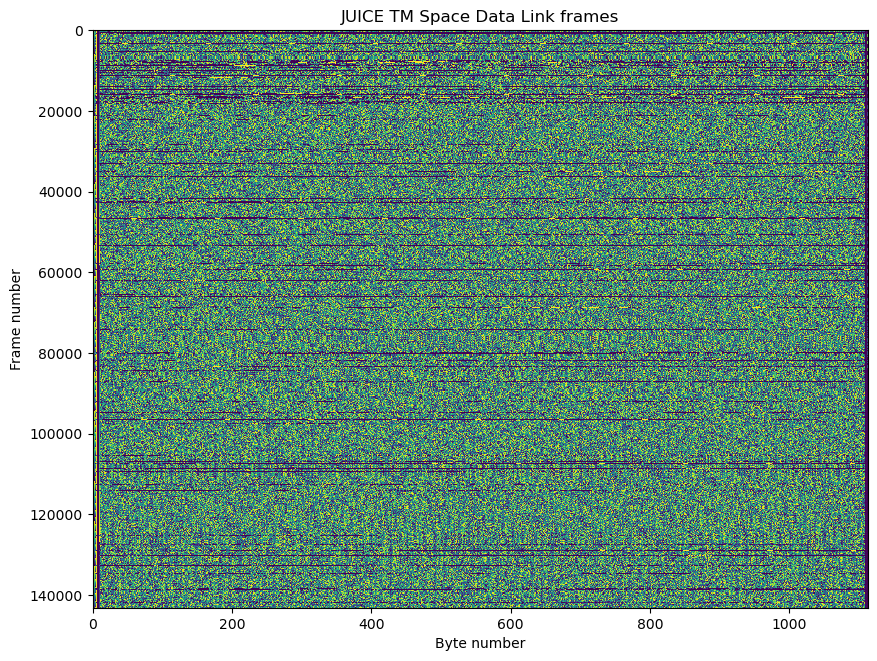

In [14]:
plt.figure(figsize=(10, 7.5))
plt.imshow(frames, aspect='auto', interpolation='none')
plt.title('JUICE TM Space Data Link frames')
plt.xlabel('Byte number')
plt.ylabel('Frame number');

In [15]:
mcfc_unwrap = np.empty(frames.shape[0], 'int')
last = 0
for j in range(frames.shape[0]):
    mcfc_unwrap[j] = (mcfc[j] + (last // 256) * 256
                      if last % 256 < mcfc[j]
                      else mcfc[j] + (last // 256 + 1) * 256)
    last = mcfc_unwrap[j]
    
mcfc_unwrap[45332:] += 17 * 256
mcfc_unwrap[45346:] += 3 * 256
mcfc_unwrap[70827:] += 18 * 256
mcfc_unwrap[70837:] += 3 * 256

In [16]:
total_frame_count = np.empty(frames.shape[0], 'int')
last_vcfc = {}
last = 0
for j in range(frames.shape[0]):
    L = last_vcfc.get(vcid[j], vcfc_extended[j] - 1)
    last_vcfc[vcid[j]] = vcfc_extended[j]
    last += vcfc_extended[j] - L
    total_frame_count[j] = last

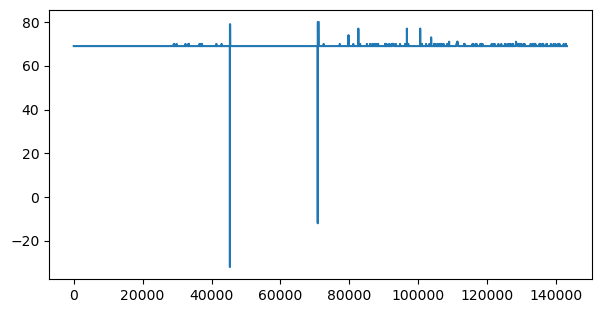

In [17]:
plt.plot(mcfc_unwrap - total_frame_count)

In [18]:
t_frame = (np.datetime64(np.datetime64('2023-04-15T05:33:31'))
           + (mcfc_unwrap - mcfc_unwrap[0]) * frame_duration * 1e9 * np.timedelta64(1, 'ns'))

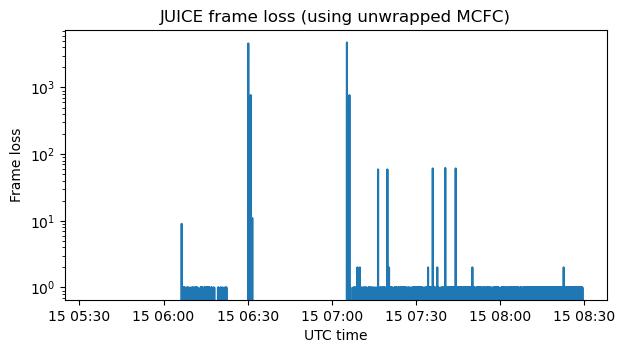

In [19]:
plt.semilogy(t_frame[1:], np.diff(mcfc_unwrap) - 1)
plt.title('JUICE frame loss (using unwrapped MCFC)')
plt.xlabel('UTC time')
plt.ylabel('Frame loss');

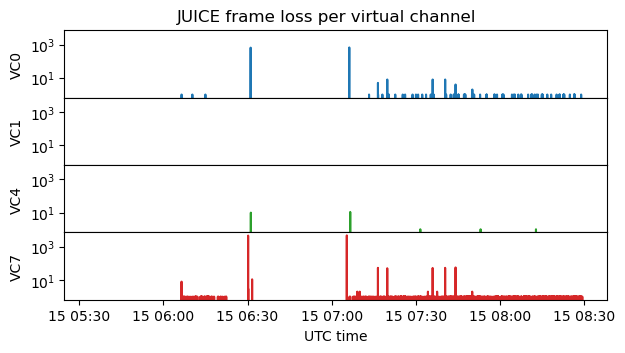

In [20]:
fig, axs = plt.subplots(len(set(vcid)), sharex=True, sharey=True)
for j, v in enumerate(sorted(set(vcid))):
    axs[j].semilogy(t_frame[vcid==v][1:],
                    np.diff(vcfc_extended[vcid == v]) - 1,
                    color=f'C{j}')
    axs[j].set_ylabel(f'VC{v}')
plt.subplots_adjust(hspace=0)
plt.suptitle('JUICE frame loss per virtual channel', y=0.94)
axs[-1].set_xlabel('UTC time');

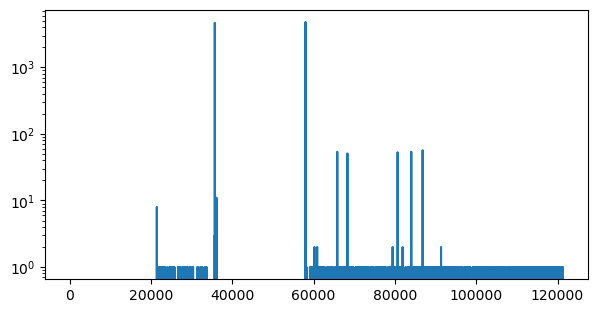

In [21]:
plt.semilogy(np.diff(vcfc_extended[vcid == 7]) - 1)

In [22]:
np.average(np.diff(vcfc_extended[vcid == 7])[22000:35500]- 1)

0.00362962962962963

In [23]:
np.average(np.diff(vcfc_extended[vcid == 7])[60000:]- 1)

0.012559125754363073

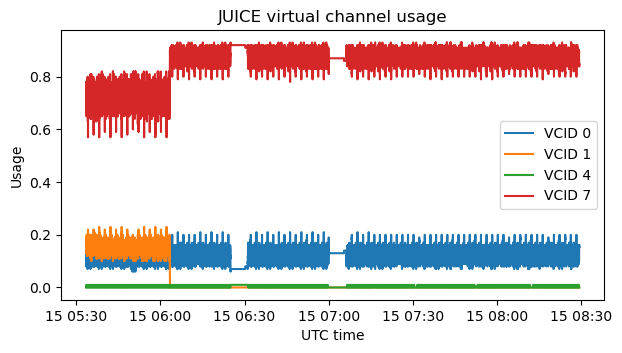

In [24]:
navg = 100
for v in sorted(set(vcid)):
    plt.plot(t_frame[:-navg+1], np.convolve(np.ones(navg)/navg, vcid == v, mode='valid'), label=f'VCID {v}')
plt.legend()
plt.title('JUICE virtual channel usage')
plt.ylabel('Usage')
plt.xlabel('UTC time');

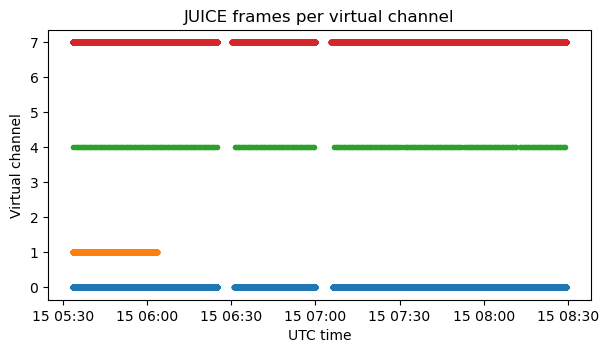

In [25]:
for v in sorted(set(vcid)):
    plt.plot(t_frame[vcid == v], np.ones(np.sum(vcid == v)) * v, '.')
plt.ylabel('Virtual channel')
plt.xlabel('UTC time')
plt.title('JUICE frames per virtual channel');

# VC0

Virtual channel 0 contains CCSDS Space Packets. There are a large number of APIDs in use. Most of the APIDs contain PUS packets following [ECSS-E-70-41A](https://cwe.ccsds.org/moims/docs/Work%20Completed%20(Closed%20WGs)/Packet%20Utilization%20Standard%20Birds%20of%20a%20Feather/Meeting%20Materials/200909%20Background/ECSS-E-70-41A(30Jan2003).pdf) (PUS version number 1).

Regarding PUS packets:
- The packet sub-counter field is not present
- The destination ID field is 8 bits wide (it always has the value `0x00`)
- The time field is 48 bits wide and contains the number of `2**(-16)` second ticks since the J2000 epoch (alternative interpretation: the destination ID field is not present and the time field is 56 bits wide)
- The spare field is not present

APID 0 does not use PUS, but it contains a secondary header with a 48-bit time field in the same format as the PUS packets.

APID 2047 is the idle APID. Packets in this APID have an 8-byte payload with random-like data and the sequence count field set to zero. They are used to "flush" the remaining part of a frame when there are no other Space Packets to fill the frame to completion.

In [26]:
vc0_packets = list(ccsds.extract_space_packets(tm, 0x34c, 0))
vc0_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc0_packets]

/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 238, current frame count 240
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 146, current frame count 148
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 133, current frame count 135
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserW

/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 168, current frame count 170
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 176, current frame count 178
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 131, current frame count 133
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserW

/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 71, current frame count 73
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 89, current frame count 91
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 0] Broken stream. Last frame count 102, current frame count 104
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarni

In [27]:
vc0_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1476, sequence_flags=3, packet_sequence_count_or_name=12663, data_length=21),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=173, sequence_flags=3, packet_sequence_count_or_name=16338, data_length=338),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1492, sequence_flags=3, packet_sequence_count_or_name=12635, data_length=21),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=173, sequence_flags=3, packet_sequence_count_or_name=16339, data_length=103),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=164, sequence_flags=3, packet_sequence_count_or_name=5519, data_length=445)]

In [28]:
vc0_apids = collections.Counter([p.APID for p in vc0_headers])
vc0_apids

Counter({1476: 4881,
         173: 18493,
         1492: 4879,
         164: 7062,
         165: 6892,
         2047: 203553,
         0: 549,
         162: 1953,
         172: 164,
         166: 18,
         161: 240,
         529: 2,
         209: 2,
         215: 1,
         163: 2})

In [29]:
collections.Counter([(p.APID, p.secondary_header_flag) for p in vc0_headers])

Counter({(1476, True): 4881,
         (173, True): 18493,
         (1492, True): 4879,
         (164, True): 7062,
         (165, True): 6892,
         (2047, False): 203553,
         (0, False): 549,
         (162, True): 1953,
         (172, True): 164,
         (166, True): 18,
         (161, True): 240,
         (529, True): 2,
         (209, True): 2,
         (215, True): 1,
         (163, True): 2})

In [30]:
for apid in sorted(vc0_apids):
    print('APID', apid)
    print('data_lengths', collections.Counter([p.data_length for p in vc0_headers if p.APID == apid]))

APID 0
data_lengths Counter({10: 549})
APID 161
data_lengths Counter({15: 238, 11: 2})
APID 162
data_lengths Counter({101: 978, 85: 975})
APID 163
data_lengths Counter({631: 2})
APID 164
data_lengths Counter({183: 980, 352: 973, 729: 973, 445: 972, 140: 971, 578: 650, 232: 326, 451: 325, 381: 324, 320: 322, 259: 164, 806: 82})
APID 165
data_lengths Counter({47: 974, 417: 973, 1987: 970, 357: 487, 3971: 484, 192: 327, 466: 326, 96: 326, 166: 325, 810: 325, 673: 325, 112: 324, 43: 324, 161: 162, 1673: 160, 3443: 80})
APID 166
data_lengths Counter({2470: 16, 941: 2})
APID 172
data_lengths Counter({1175: 164})
APID 173
data_lengths Counter({338: 9737, 103: 2436, 211: 2428, 859: 1214, 219: 975, 366: 608, 83: 607, 1988: 326, 3611: 162})
APID 209
data_lengths Counter({15: 2})
APID 215
data_lengths Counter({16: 1})
APID 529
data_lengths Counter({15: 2})
APID 1476
data_lengths Counter({21: 4881})
APID 1492
data_lengths Counter({21: 4879})
APID 2047
data_lengths Counter({7: 203553})


In [31]:
vc0_by_apid = {apid: [p for p, h in zip(vc0_packets, vc0_headers) if h.APID == apid]
               for apid in vc0_apids}
vc0_t_by_apid = {apid: np.array([(to_timestamp_pus if apid != 0 else to_timestamp_not_pus)(p)
                                 for p in vc0_by_apid[apid]])
                 for apid in vc0_apids if apid not in [2047]}
vc0_pus_by_apid = {apid: [PUSHeader.parse(p[ccsds.SpacePacketPrimaryHeader.sizeof():])
                          for p in vc0_by_apid[apid]]
                   for apid in vc0_apids if apid not in [0, 2047]}
vc0_services_by_apid = {
    apid: collections.Counter([pus_service(p) for p in vc0_pus_by_apid[apid]])
    for apid in vc0_apids if apid not in [0, 2047]}

In [32]:
collections.Counter([(p.spare_flag, p.version_number, p.spare, p.destination_id)
                     for pus in vc0_pus_by_apid.values() for p in pus])

Counter({(False, 1, 0, 0): 44589})

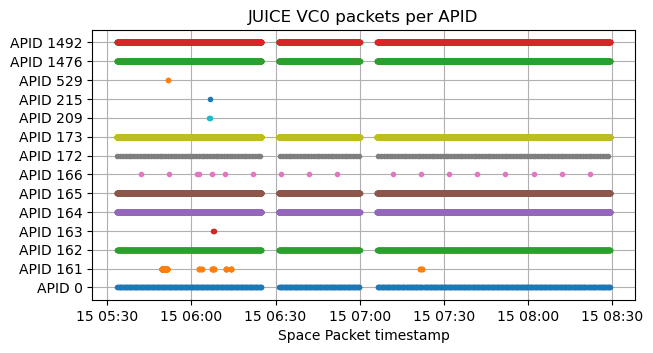

In [33]:
apid_list = sorted([a for a in vc0_apids if a not in [2047]])
for j, apid in enumerate(apid_list):
    plt.plot(vc0_t_by_apid[apid], np.ones(vc0_t_by_apid[apid].size) * j, '.'),
plt.yticks(np.arange(len(apid_list)), [f'APID {a}' for a in apid_list])
plt.grid()
plt.title('JUICE VC0 packets per APID')
plt.xlabel('Space Packet timestamp');

In [34]:
sec_avg = 100
tslices = np.datetime64('2023-04-15T05:30') + np.arange(3 * 3600 / sec_avg + 1) * np.timedelta64(sec_avg, 's')

In [35]:
vc0_packets_per_second = {
    apid:
    [np.sum((tslices[j] <= vc0_t_by_apid[apid]) & (vc0_t_by_apid[apid] < tslices[j+1])) / sec_avg
     for j in range(len(tslices) - 1)]
    for apid in vc0_apids if apid not in [2047]}

vc0_bytes_per_second = {
    apid:
    [np.sum([len(p) for p, t in zip(vc0_by_apid[apid], vc0_t_by_apid[apid])
             if tslices[j] <= t < tslices[j+1]]) / sec_avg
     for j in range(len(tslices) - 1)]
    for apid in vc0_apids if apid not in [2047]}

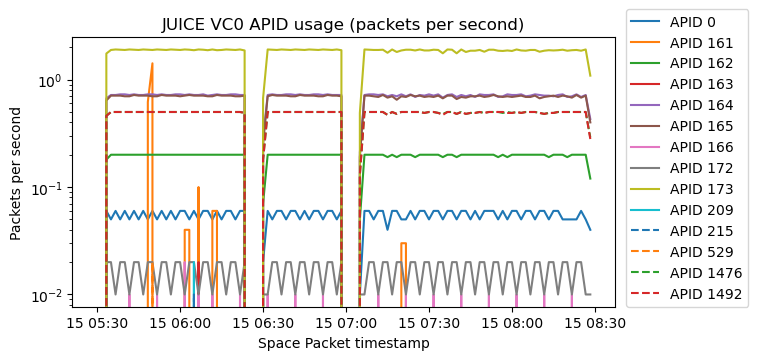

In [36]:
for j, apid in enumerate(sorted(vc0_packets_per_second)):
    plt.semilogy(tslices[:-1], vc0_packets_per_second[apid], label=f'APID {apid}',
                 linestyle='--' if j >= 10 else '-')
plt.legend(loc=[1.02,0])
plt.title('JUICE VC0 APID usage (packets per second)')
plt.ylabel('Packets per second')
plt.xlabel('Space Packet timestamp');

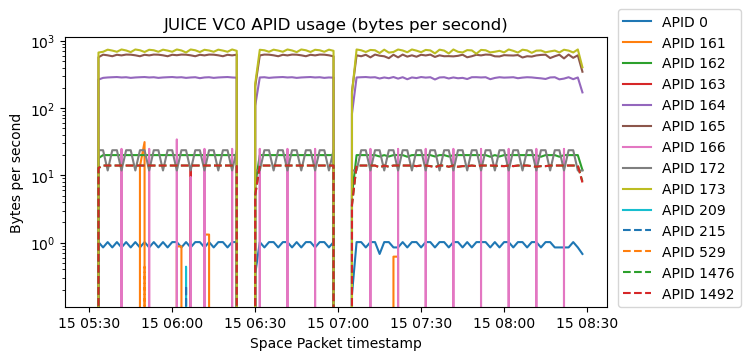

In [37]:
for j, apid in enumerate(sorted(vc0_bytes_per_second)):
    plt.semilogy(tslices[:-1], vc0_bytes_per_second[apid], label=f'APID {apid}',
                 linestyle='--' if j >= 10 else '-')
plt.legend(loc=[1.02,0])
plt.ylabel('Bytes per second')
plt.title('JUICE VC0 APID usage (bytes per second)')
plt.xlabel('Space Packet timestamp');

In [38]:
collections.Counter([(p.spare_flag, p.version_number, p.destination_id)
                     for a in vc0_pus_by_apid.values() for p in a])

Counter({(False, 1, 0): 44589})

In [39]:
packet_crc = crc(16, 0x1021, 0xffff, 0x0, False, False)
packet_crc_ok = [packet_crc.compute(list(p[:-2])) == struct.unpack('>H', p[-2:])[0]
                 for p in vc0_packets if ccsds.SpacePacketPrimaryHeader.parse(p).APID != 2047]
all(packet_crc_ok)

True

## APID 0

In [40]:
[p[6:].hex() for p in vc0_by_apid[0]]

['052f2bccf3aa7ca7fc5843',
 '052f2bccf3bbc68dc4516d',
 '052f2bccf3cf83be718047',
 '052f2bccf3de6bc6110ae7',
 '052f2bccf3f2061d3fa24f',
 '052f2bccf401d0aa958671',
 '052f2bccf41513e208da42',
 '052f2bccf42916c5b2c8fc',
 '052f2bccf4398f92829117',
 '052f2bccf44c248a7bd5d3',
 '052f2bccf45e73cf77c3bc',
 '052f2bccf4714e7a6df61e',
 '052f2bccf481702781f629',
 '052f2bccf493d0d93b8850',
 '052f2bccf4a642f7b6788a',
 '052f2bccf4b7d2907ae4a8',
 '052f2bccf4c90b09823679',
 '052f2bccf4dd1f59ecf82e',
 '052f2bccf4eed1cc2e64b6',
 '052f2bccf5020396e1c469',
 '052f2bccf514a9fb98155d',
 '052f2bccf525570ea5bfec',
 '052f2bccf537c92d21e2b1',
 '052f2bccf54887aced419a',
 '052f2bccf55c7923d80050',
 '052f2bccf56c77f76c0a71',
 '052f2bccf57db07074dd78',
 '052f2bccf591907a9f309d',
 '052f2bccf5a459b8d6b413',
 '052f2bccf5b4afac283c55',
 '052f2bccf5c778ea5eaf20',
 '052f2bccf5d94e3620adbe',
 '052f2bccf5ea5268e94cc3',
 '052f2bccf5fd615a1d55a5',
 '052f2bccf610704b52f36a',
 '052f2bccf620e918212f46',
 '052f2bccf6311c31f578ef',
 

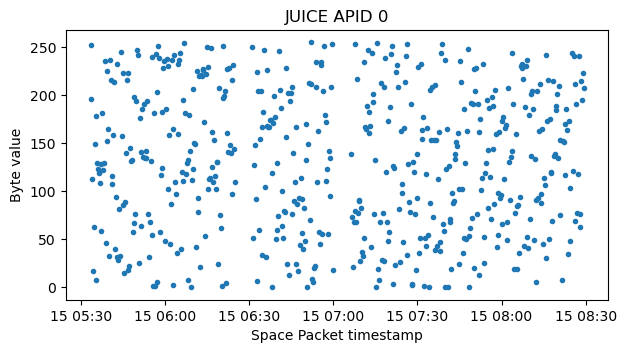

In [41]:
apid0 = np.array([np.frombuffer(a[14:-2], 'uint8') for a in vc0_by_apid[0]])
plt.plot(vc0_t_by_apid[0], apid0, '.')
plt.title(f'JUICE APID 0')
plt.xlabel('Space Packet timestamp')
plt.ylabel('Byte value');

## APID 161

In [42]:
vc0_services_by_apid[161]
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)
# (17, 2) is link connection report (test service)

Counter({(1, 1): 119, (1, 7): 119, (17, 2): 2})

In [43]:
[a[6:].hex() for a in vc0_by_apid[161]]

['100101002bccf768a29718acca9dc0b4',
 '100107002bccf768a2ca18acca9def20',
 '100101002bccf769a28b18acca9e229b',
 '100107002bccf769a2c018acca9ec4d0',
 '100101002bccf76aa30718acca9f27a7',
 '100107002bccf76aa33a18acca9f11ef',
 '100101002bccf76b43a618accaa0313b',
 '100107002bccf76b43da18accaa0bc4a',
 '100101002bccf76c43a318accaa13acd',
 '100107002bccf76c43d718accaa1b591',
 '100101002bccf76d633e18accaa24768',
 '100107002bccf76d637218accaa2c6f7',
 '100101002bccf76e634a18accaa33a8f',
 '100107002bccf76e637e18accaa3a4bb',
 '100101002bccf76fe23618accaa49768',
 '100107002bccf76fe26b18accaa4b8fc',
 '100101002bccf770e2c318accaa5071e',
 '100107002bccf770e2f418accaa577f8',
 '100101002bccf771e23618accaa67641',
 '100107002bccf771e26b18accaa659d5',
 '100101002bccf77282be18accaa7e0c3',
 '100107002bccf77282f018accaa725df',
 '100101002bccf773830318accaa881e5',
 '100107002bccf773833518accaa85b52',
 '100101002bccf774a24618accaa9ebd3',
 '100107002bccf774a28318accaa9e0e0',
 '100101002bccf775a29e18accaaaad43',
 

In [44]:
vc0_pus_by_apid[161]

[Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=0),
 Container

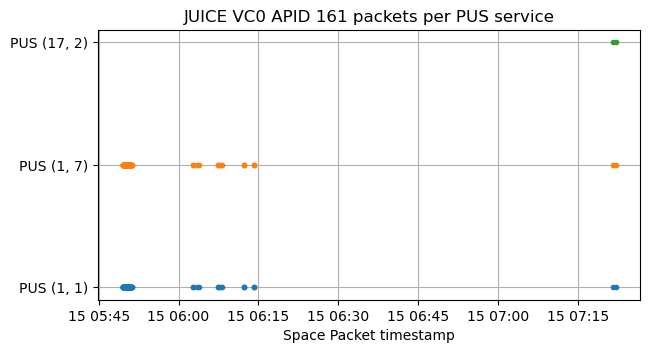

In [45]:
for j, service in enumerate(vc0_services_by_apid[161]):
    sel = [pus_service(p) == service for p in vc0_pus_by_apid[161]]
    plt.plot(vc0_t_by_apid[161][sel], np.ones(np.sum(sel)) * j, '.')
plt.yticks(np.arange(len(vc0_services_by_apid[161])), [f'PUS {a}' for a in vc0_services_by_apid[161]])
plt.grid()
plt.title('JUICE VC0 APID 161 packets per PUS service')
plt.xlabel('Space Packet timestamp');

In [46]:
# PUS (1, 1) and (1, 7) contain as payload the corresponding Space Packet header minus the data length field
service1_payloads = [
    ccsds.SpacePacketPrimaryHeader.parse(a[-6:-2] + b'\x00\x00')
    for a, p in zip(vc0_by_apid[161], vc0_pus_by_apid[161])
    if p.service_type == 1]
service1_payloads

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=172, sequence_flags=3, packet_sequence_count_or_name=2717, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=172, sequence_flags=3, packet_sequence_count_or_name=2717, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=172, sequence_flags=3, packet_sequence_count_or_name=2718, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=172, sequence_flags=3, packet_sequence_count_or_name=2718, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=172, sequence_flags=3, packet_sequence_count_or_name=2719, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=172, sequence_flags=3, packet_sequence_count_or_name=2719, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=172, sequence_flag

In [47]:
vc0_t_by_apid[161]

array(['2023-04-15T05:49:28.635116544', '2023-04-15T05:49:28.635894784',
       '2023-04-15T05:49:29.634933504', '2023-04-15T05:49:29.635742208',
       '2023-04-15T05:49:30.636825600', '2023-04-15T05:49:30.637603712',
       '2023-04-15T05:49:31.264251648', '2023-04-15T05:49:31.265045120',
       '2023-04-15T05:49:32.264205952', '2023-04-15T05:49:32.264999424',
       '2023-04-15T05:49:33.387664768', '2023-04-15T05:49:33.388458240',
       '2023-04-15T05:49:34.387847936', '2023-04-15T05:49:34.388641408',
       '2023-04-15T05:49:35.883636480', '2023-04-15T05:49:35.884445184',
       '2023-04-15T05:49:36.885787904', '2023-04-15T05:49:36.886535680',
       '2023-04-15T05:49:37.883636480', '2023-04-15T05:49:37.884445184',
       '2023-04-15T05:49:38.510711680', '2023-04-15T05:49:38.511474560',
       '2023-04-15T05:49:39.511764480', '2023-04-15T05:49:39.512527488',
       '2023-04-15T05:49:40.633880576', '2023-04-15T05:49:40.634811392',
       '2023-04-15T05:49:41.635223424', '2023-04-15

## APID 162

In [48]:
vc0_services_by_apid[162]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 1953})

In [49]:
apid162_sids = collections.Counter(a[16:20].hex() for a in vc0_by_apid[162])
apid162_sids

Counter({'00000002': 975, '00000003': 978})

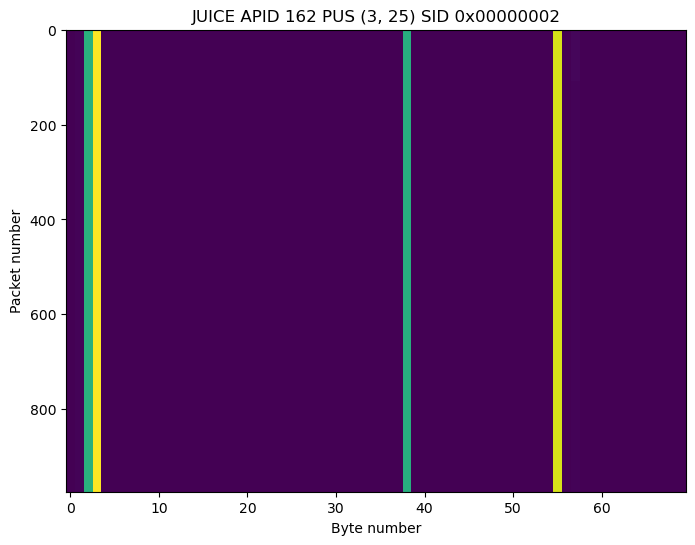

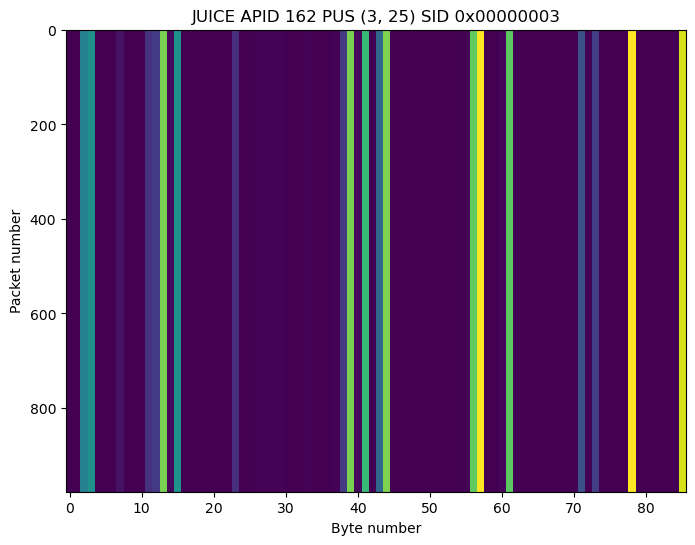

In [50]:
for sid in sorted(apid162_sids):
    apid162_sid = np.array([np.frombuffer(a[20:-2], 'uint8') for a in vc0_by_apid[162]
                            if a[16:20].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid162_sid, aspect='auto', interpolation='none')
    plt.title(f'JUICE APID 162 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

## APID 163

In [51]:
vc0_services_by_apid[163]
# (156, 2) mission defined

Counter({(156, 2): 2})

In [52]:
[a[6:].hex() for a in vc0_by_apid[163]]

['109c02002bccfba9fbb70000006f0000000000000260000000050000000500000000000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000010000000100000001000000000000000000000000000000000000000000000001000000010000000100000001000000010000000100000001000000010000000100000001000000000000001f000000000000000000000000000000000000000000000019000000190000001900000019000000190000000c000000090000000c0000000c0000000c00000000000000040000000000000000000000000000000000000000000000040000000400000004000000040000000400000004000000040000000400000004000000040000000000000000000000000000000e000000080000000000000000000000010000000100000000000000000000000000000000000000000000000a0000001000000000000000000000000000000000000000000000000100000000000000020000000000000001000000000000000100000000000000000000000100000000000000000000000100000000000000000000000100000000000000000000000100000001000000000000000100000000000000000000000100000000000000000000000100

## APID 164

In [53]:
vc0_services_by_apid[164]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 7062})

In [54]:
apid164_sids = collections.Counter(a[16:20].hex() for a in vc0_by_apid[164])
apid164_sids

Counter({'0000000c': 972,
         '00000016': 650,
         '0000000d': 971,
         '00000014': 324,
         '00000012': 973,
         '00000046': 973,
         '00000010': 980,
         '0000000e': 164,
         '0000000f': 326,
         '00000017': 322,
         '00000011': 325,
         '0000000b': 82})

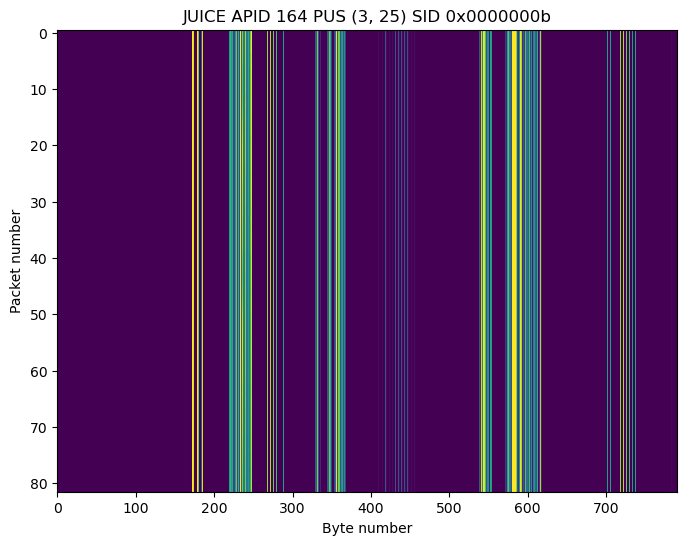

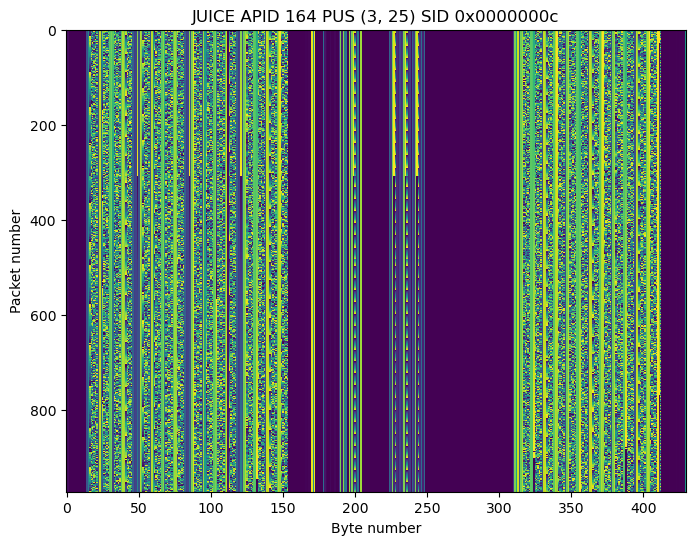

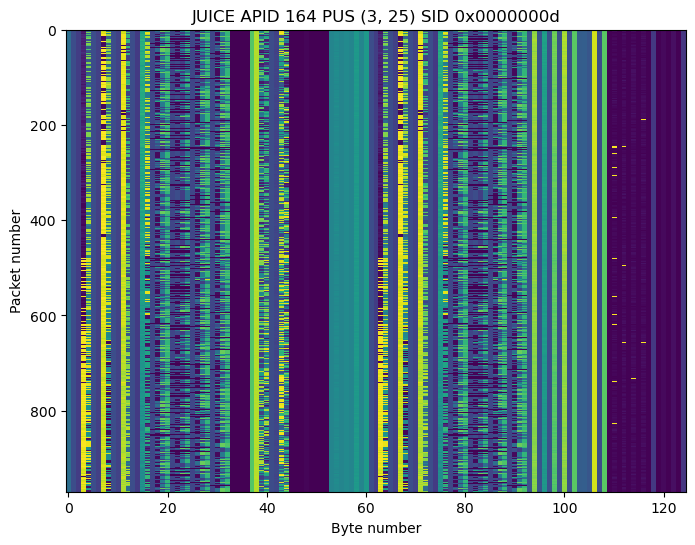

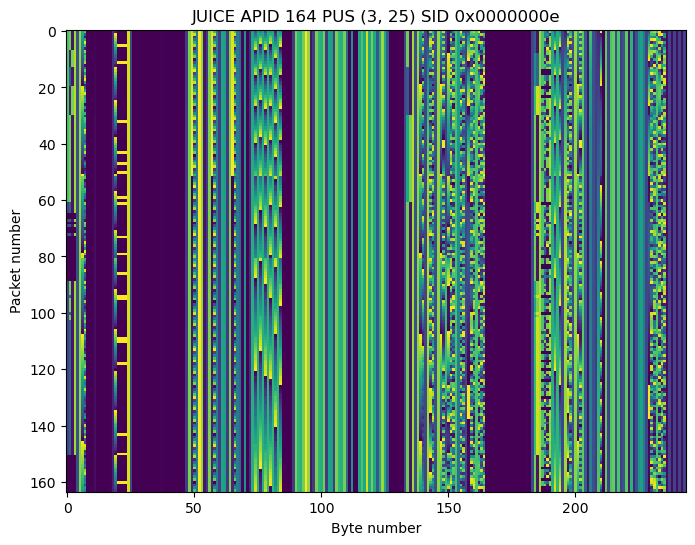

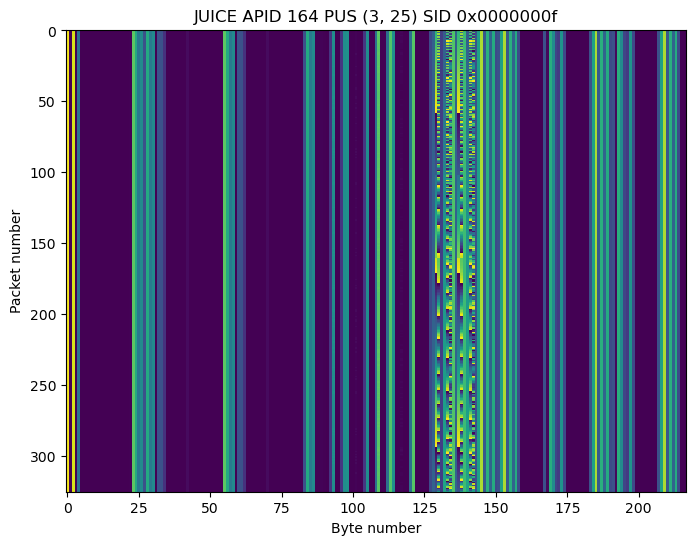

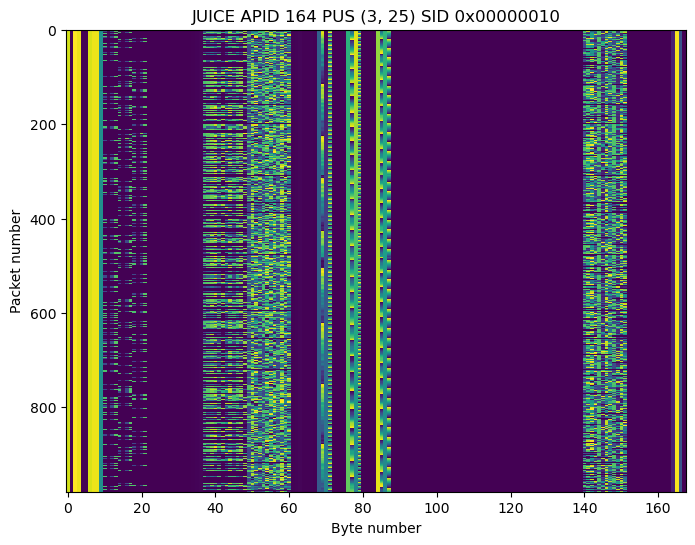

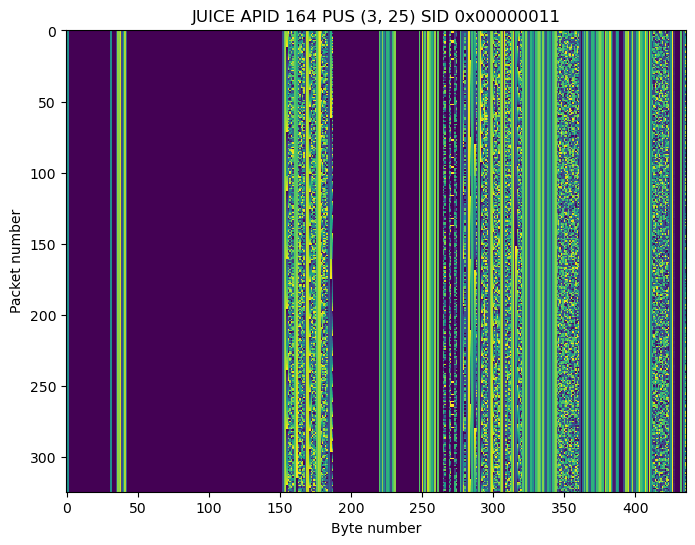

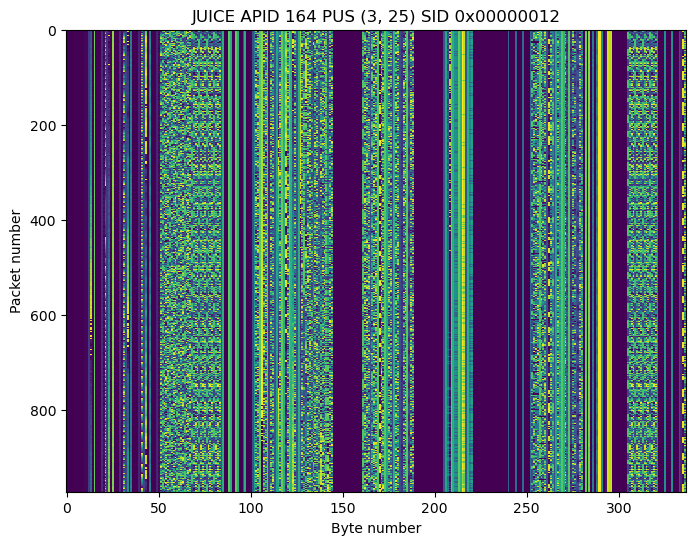

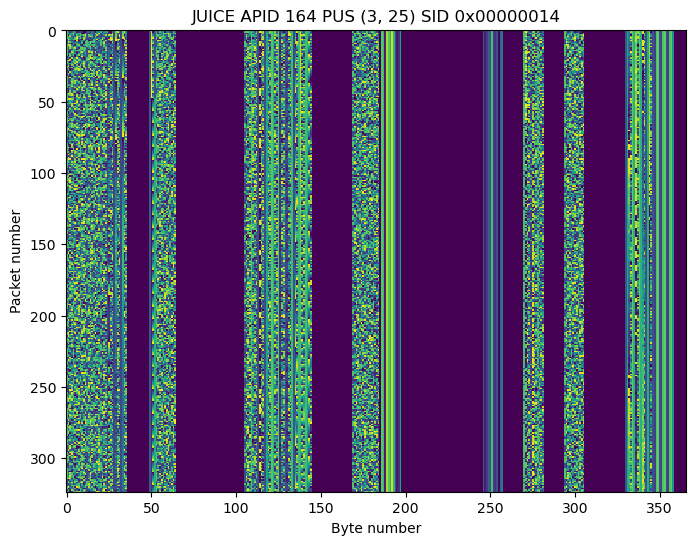

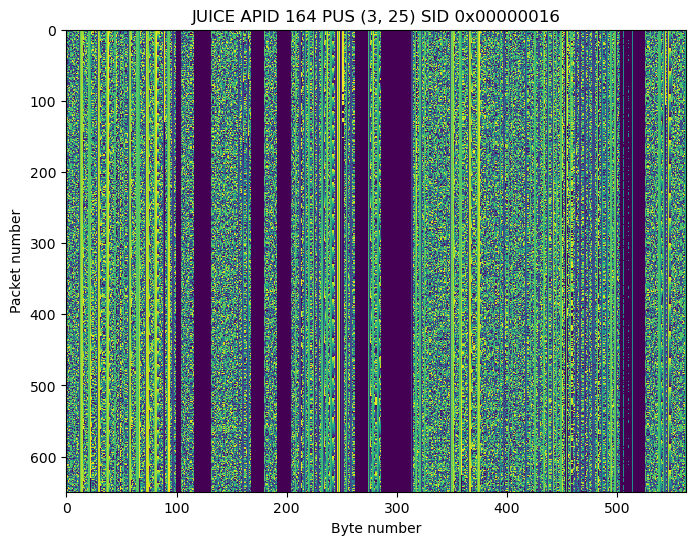

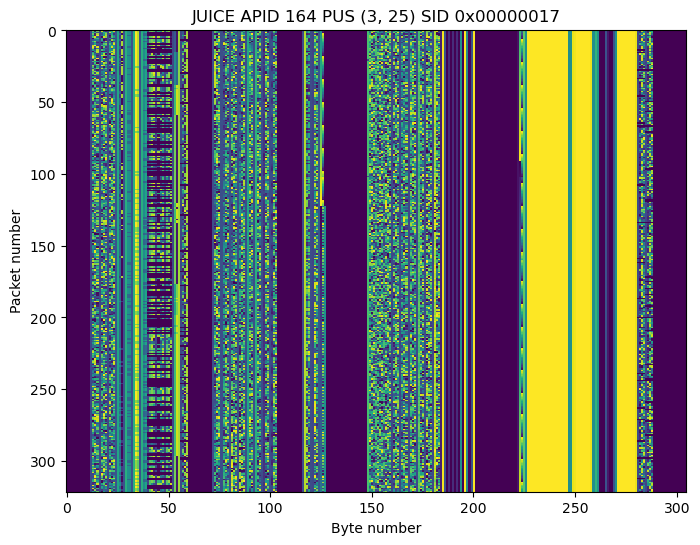

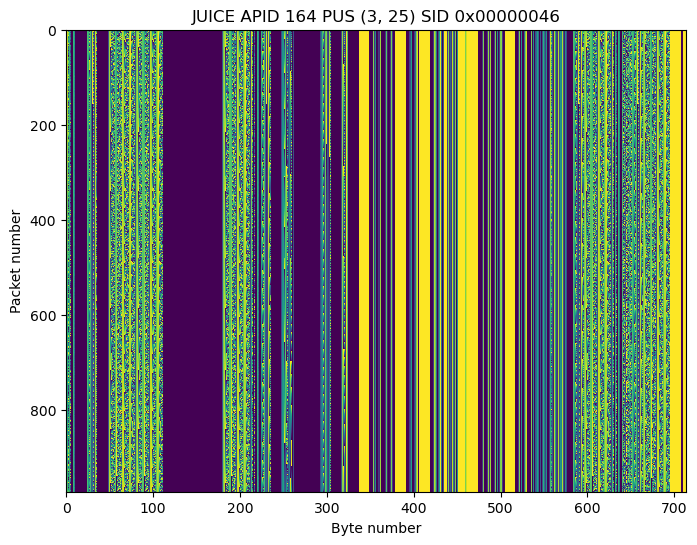

In [55]:
for sid in sorted(apid164_sids):
    apid164_sid = np.array([np.frombuffer(a[20:-2], 'uint8') for a in vc0_by_apid[164]
                            if a[16:20].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid164_sid, aspect='auto', interpolation='none')
    plt.title(f'JUICE APID 164 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

## APID 165

In [56]:
vc0_services_by_apid[165]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 6892})

In [57]:
apid165_sids = collections.Counter(a[16:20].hex() for a in vc0_by_apid[165])
apid165_sids

Counter({'0000004d': 325,
         '00000047': 970,
         '00000052': 973,
         '0000004e': 974,
         '00000048': 326,
         '00000055': 484,
         '0000004f': 327,
         '00000054': 487,
         '00000050': 324,
         '00000057': 325,
         '00000051': 326,
         '0000004b': 324,
         '00000059': 81,
         '00000053': 325,
         '00000056': 80,
         '0000004c': 160,
         '00000058': 81})

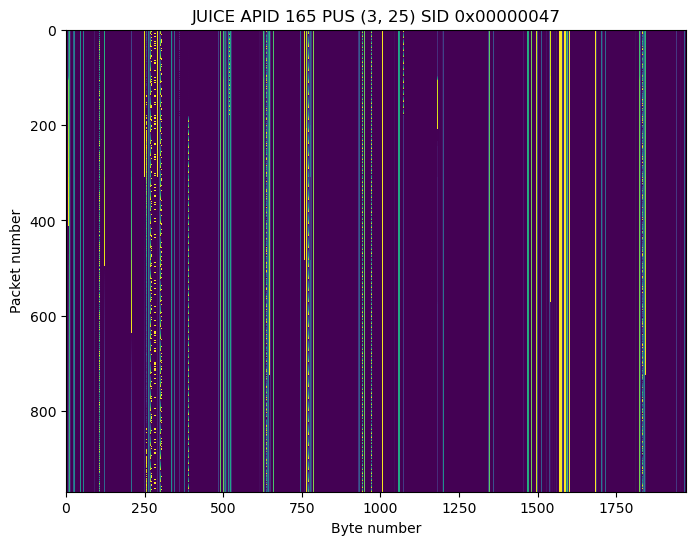

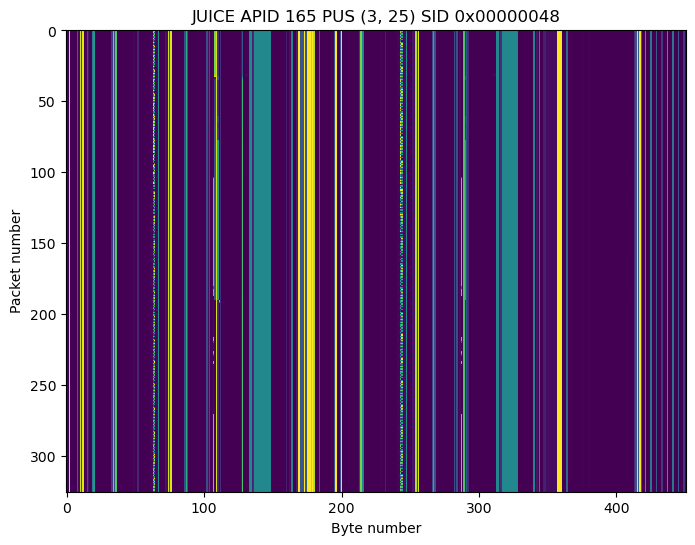

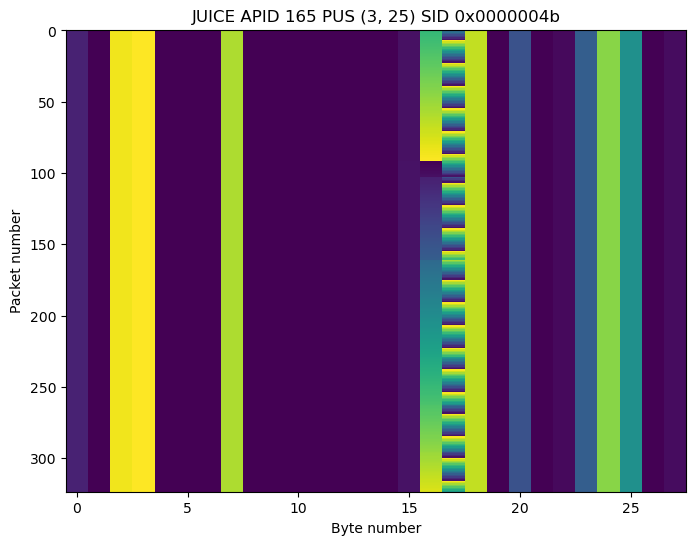

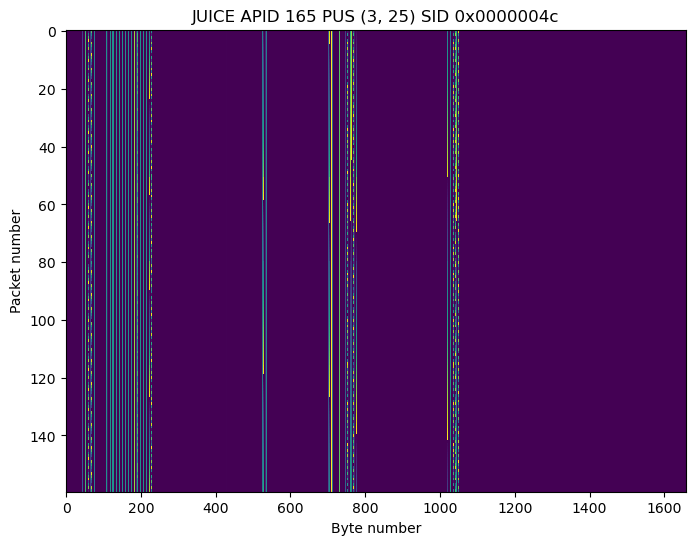

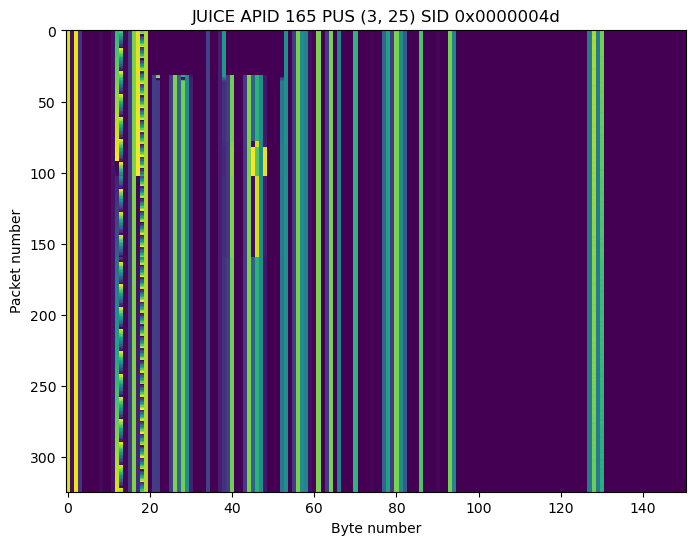

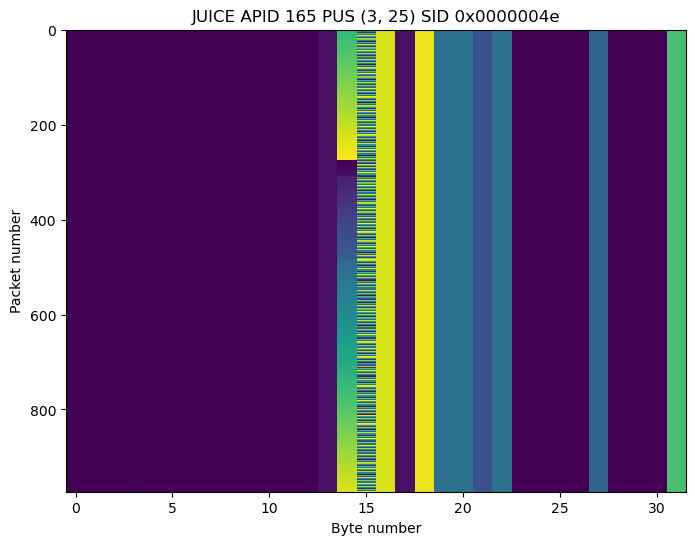

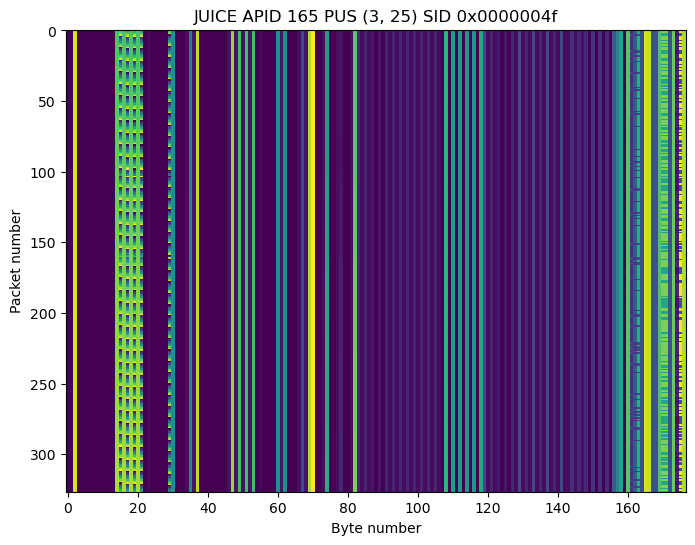

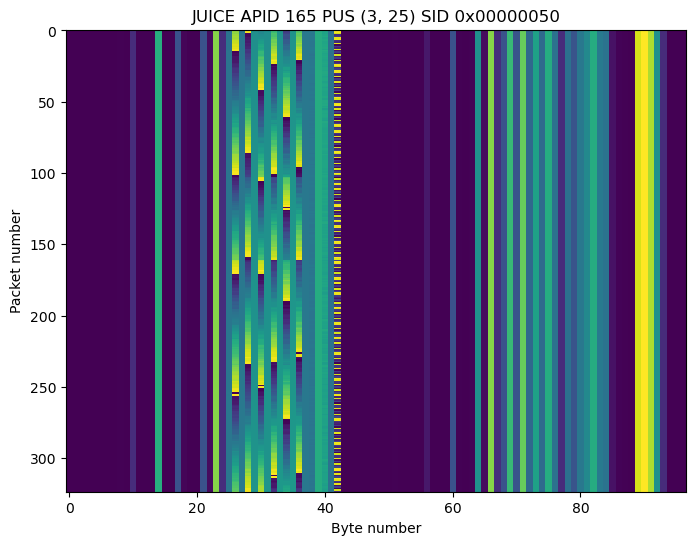

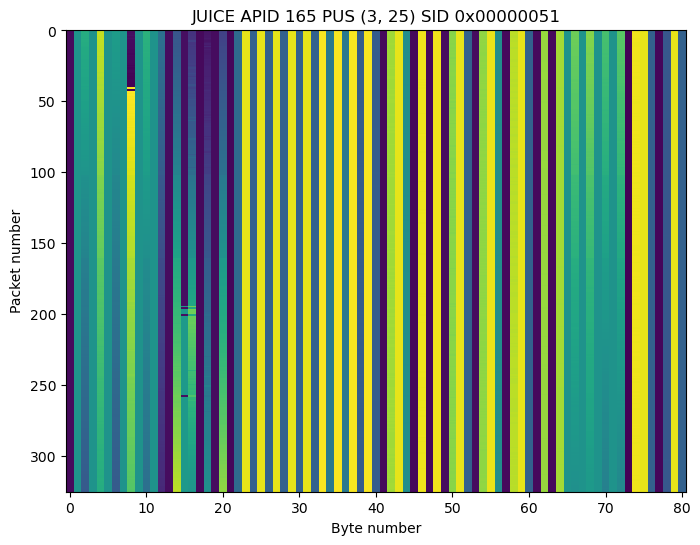

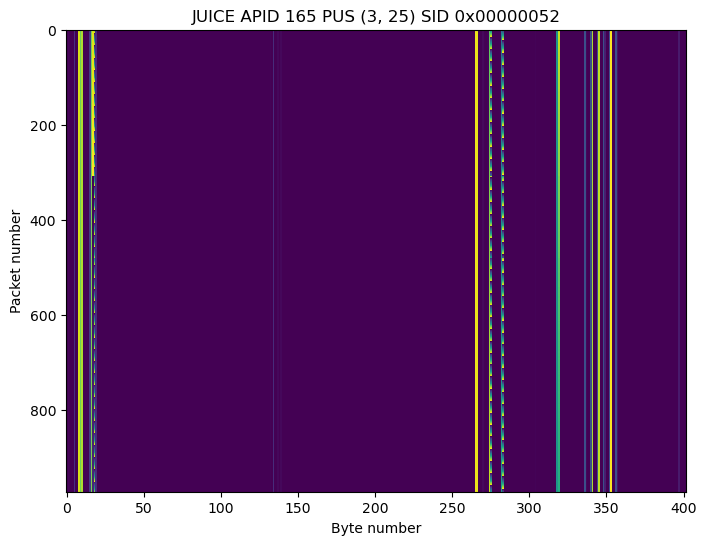

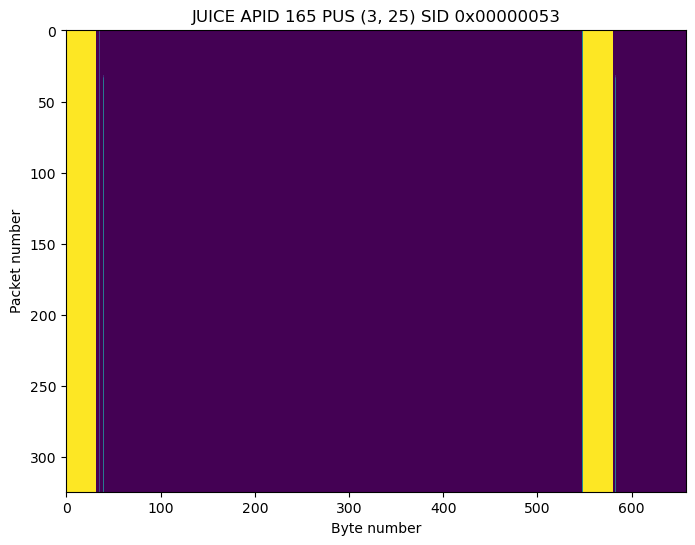

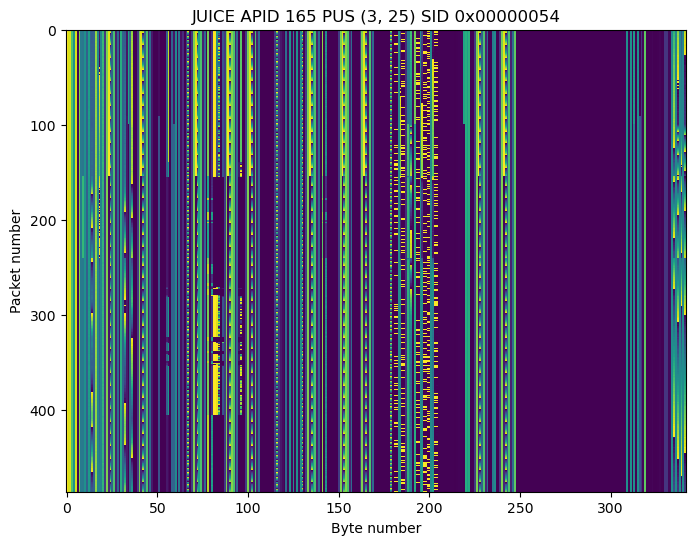

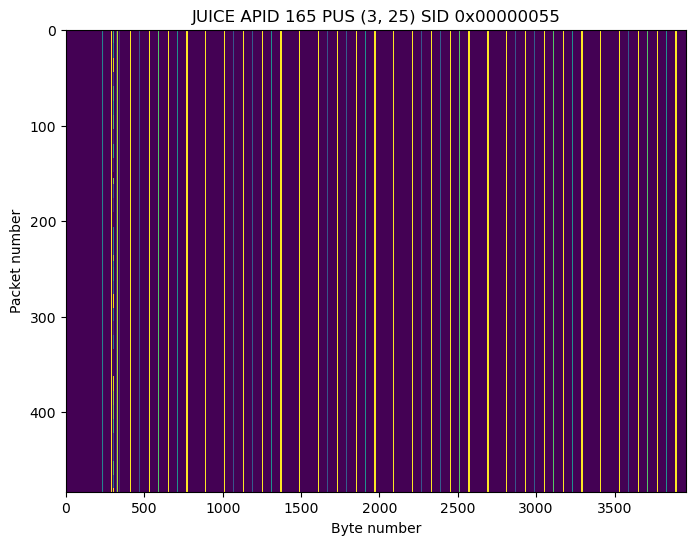

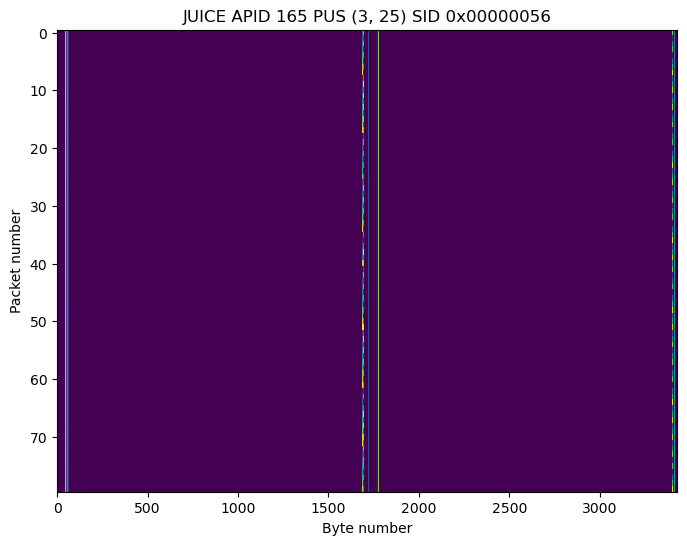

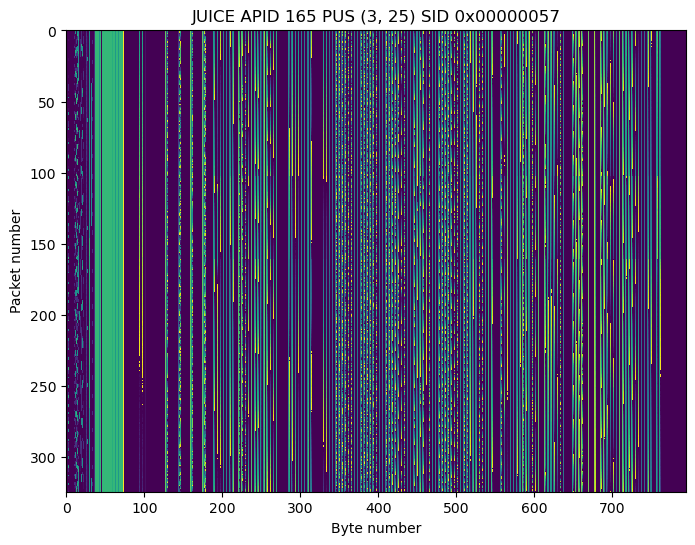

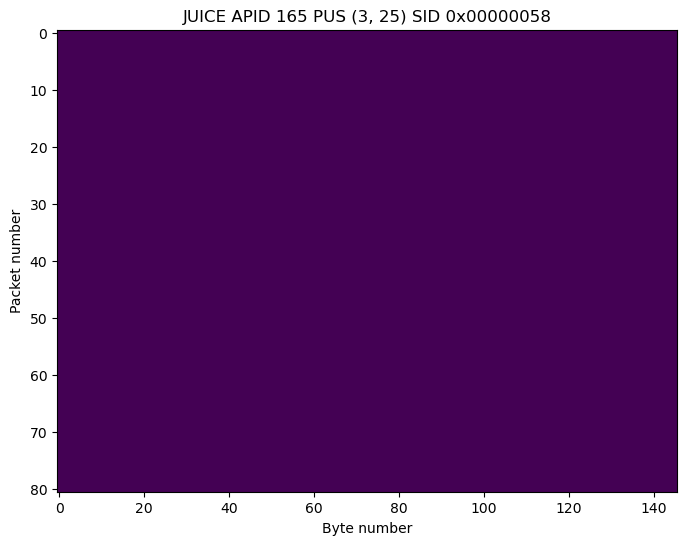

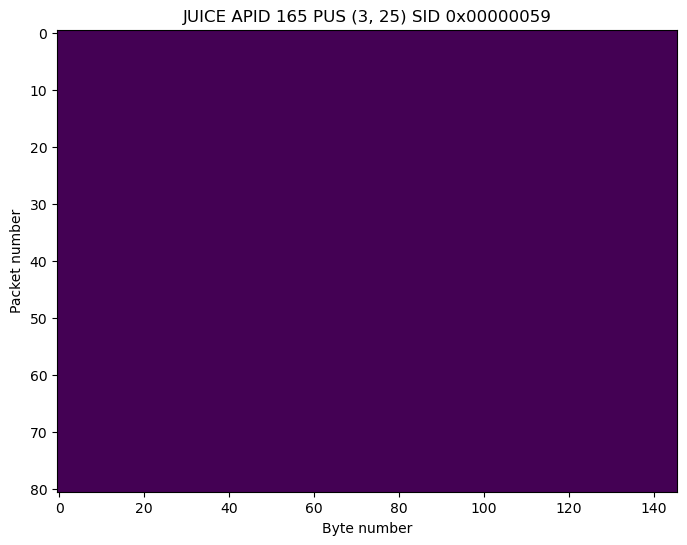

In [58]:
for sid in sorted(apid165_sids):
    apid165_sid = np.array([np.frombuffer(a[20:-2], 'uint8') for a in vc0_by_apid[165]
                            if a[16:20].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid165_sid, aspect='auto', interpolation='none')
    plt.title(f'JUICE APID 165 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

## APID 166

In [59]:
vc0_services_by_apid[166]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 18})

In [60]:
apid166_sids = collections.Counter(a[16:20].hex() for a in vc0_by_apid[166])
apid166_sids

Counter({'00000094': 16, '00000087': 2})

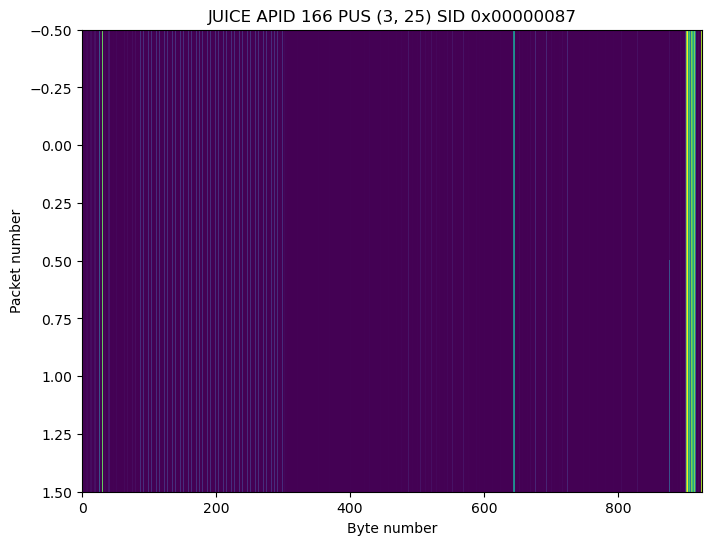

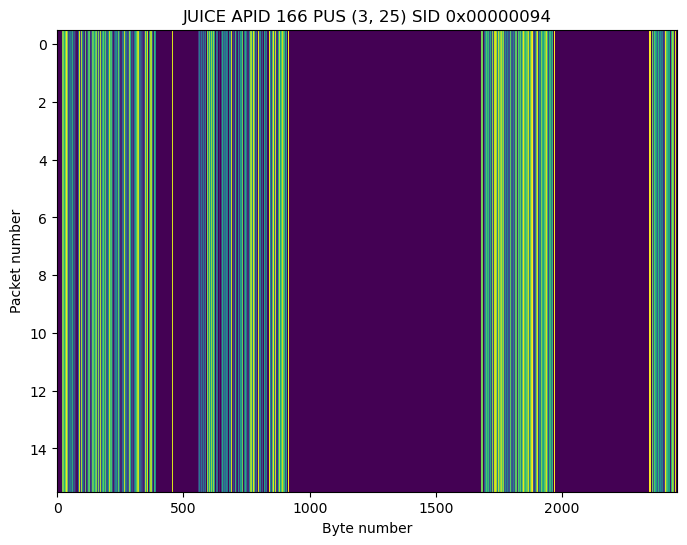

In [61]:
for sid in sorted(apid166_sids):
    apid166_sid = np.array([np.frombuffer(a[20:-2], 'uint8') for a in vc0_by_apid[166]
                            if a[16:20].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid166_sid, aspect='auto', interpolation='none')
    plt.title(f'JUICE APID 166 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

## APID 172

In [62]:
vc0_services_by_apid[172]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 164})

In [63]:
apid172_sids = collections.Counter(a[16:20].hex() for a in vc0_by_apid[172])
apid172_sids

Counter({'000000a3': 164})

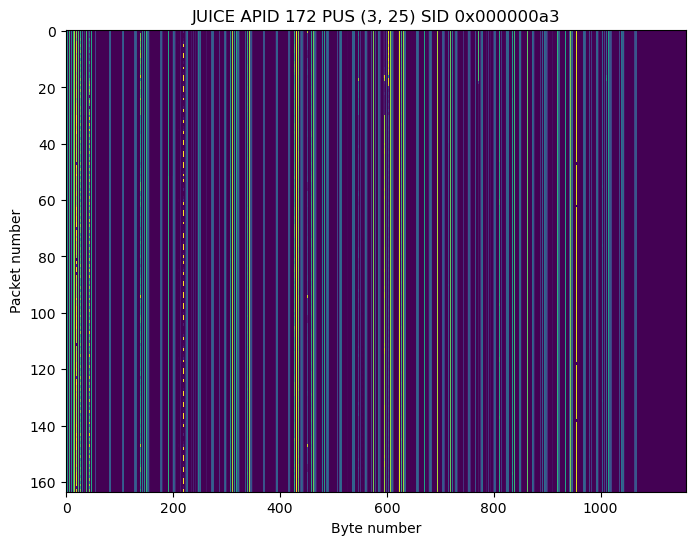

In [64]:
for sid in sorted(apid172_sids):
    apid172_sid = np.array([np.frombuffer(a[20:-2], 'uint8') for a in vc0_by_apid[172]
                            if a[16:20].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid172_sid, aspect='auto', interpolation='none')
    plt.title(f'JUICE APID 172 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

In [65]:
[a[20:-2] for a in vc0_by_apid[172]][:2]

[b'\x00\x01~\x0f\x00\x01\xa9e\x00\x01tU\x00\x01\xa8\xdd\x00\x00P\xd2\x00\x00\xd3\xb2\x00\x00U\x9a\x00\x00X7\x00\x00\x19h\x00\x01\xae\x1f\x00\x00\x1eD\x00\x00`\x9b\x00\x00\x00\x00\x00\x00\x002\x00\x00\x00\x00\x00\x00\x002\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00SIFM\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00WDIN\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00BGND\x0e\x00\x00\x00\x00\x01~\x0f\x00\x01\xa9e\x00\x01tU\x00\x01\xa8\xddNVIP\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00COMS\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x97\x00\x00\x00\x00\x00\x00\x00\x0bSSMC\x17\x00\x00\x00\x00\x00\x01\x12\x00\x00\x14\x83\x00\x00\x02\x1b\x00\x00\x03\x1aPFCY#\x00\x00\x00\x00\x00\r\xbf\x00\x00\x17\x8e\x00\x00\x0e\xdc\x00\x00\x10kPFAS%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c\xdc\x00\x00\x00\x00\x00\x00\x00\xdbCDPH\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02,\x00\x00\x00\x00\x00\x

## APID 173

In [66]:
vc0_services_by_apid[173]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 18493})

In [67]:
apid173_sids = collections.Counter(a[16:20].hex() for a in vc0_by_apid[173])
apid173_sids

Counter({'000000b0': 9737,
         '000000b5': 2436,
         '000000bd': 608,
         '000000b6': 2428,
         '000000b1': 975,
         '000000b8': 607,
         '000000ba': 607,
         '000000bb': 607,
         '000000ab': 326,
         '000000ac': 162})

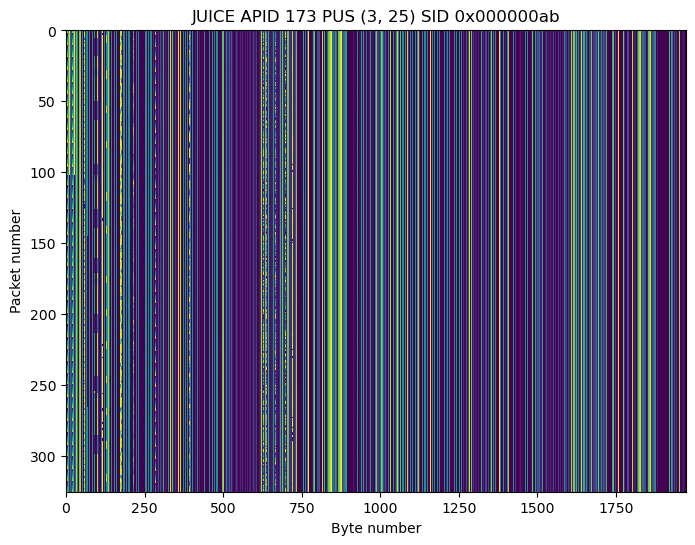

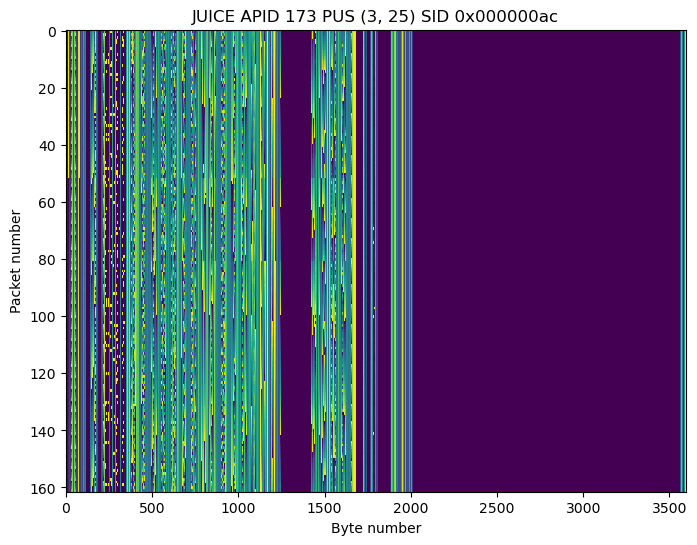

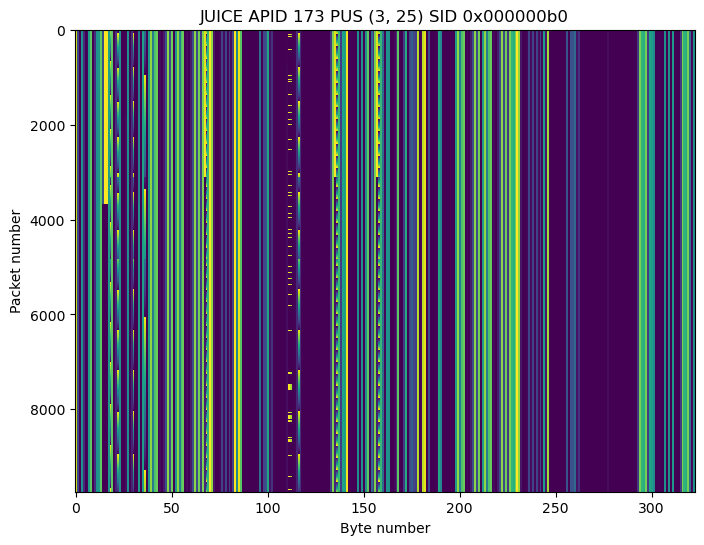

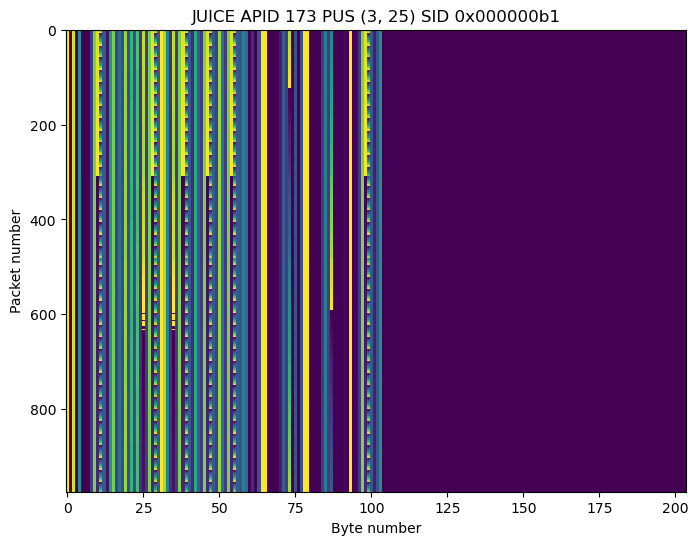

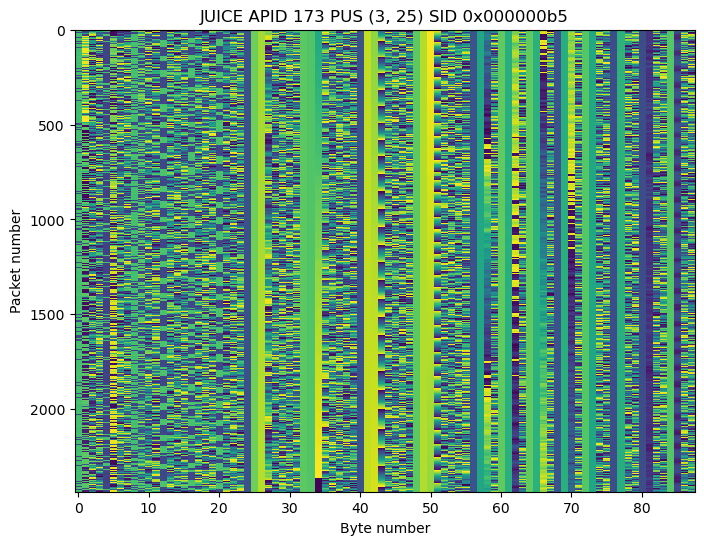

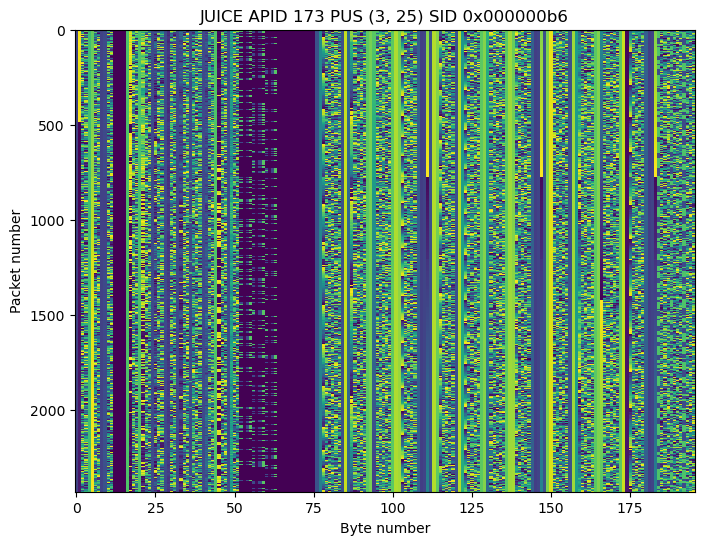

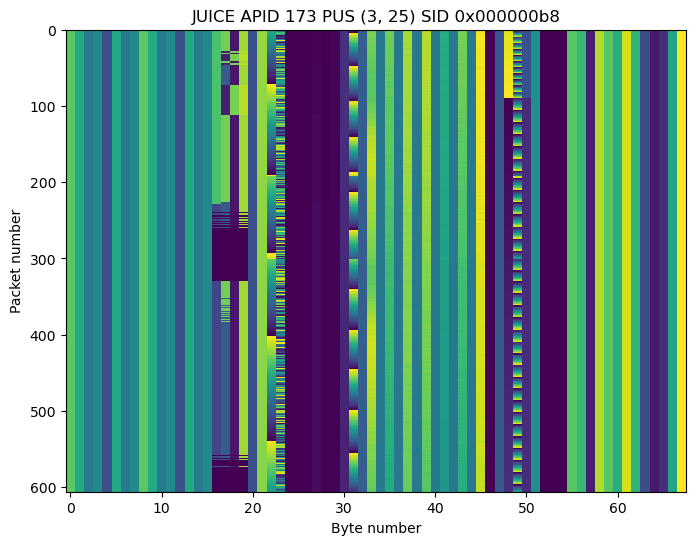

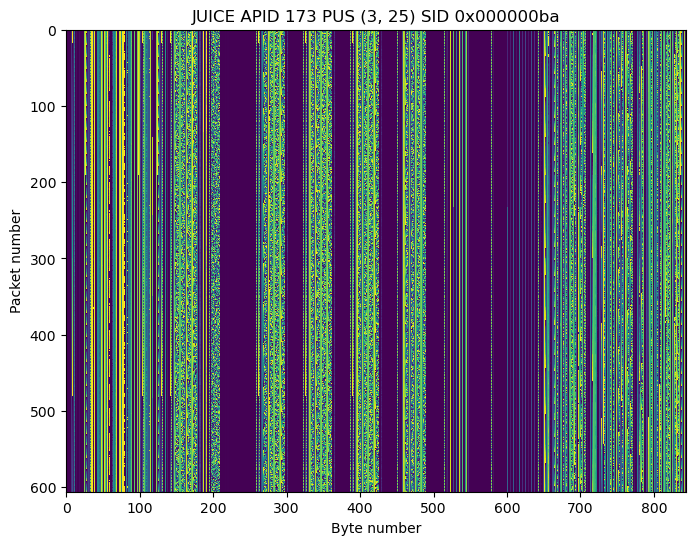

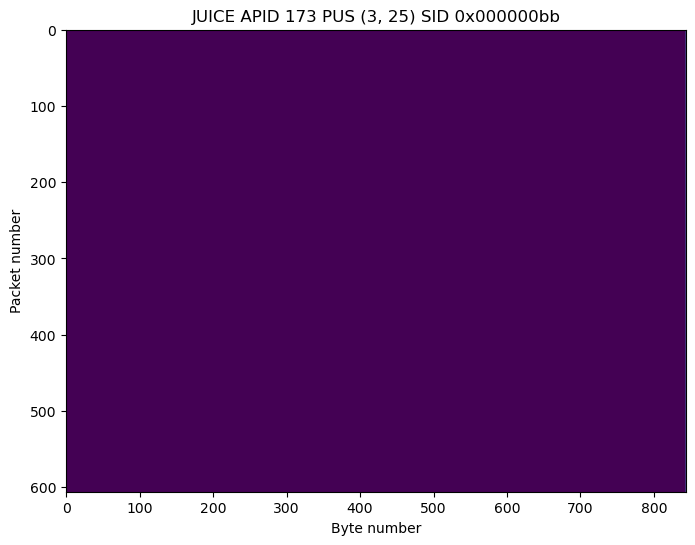

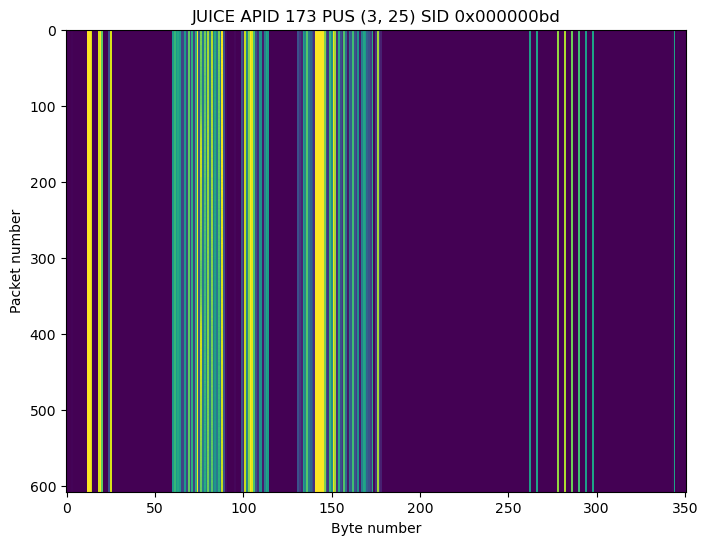

In [68]:
for sid in sorted(apid173_sids):
    apid173_sid = np.array([np.frombuffer(a[20:-2], 'uint8') for a in vc0_by_apid[173]
                            if a[16:20].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid173_sid, aspect='auto', interpolation='none')
    plt.title(f'JUICE APID 173 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

## APID 209

In [69]:
vc0_services_by_apid[209]
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)

Counter({(1, 1): 1, (1, 7): 1})

In [70]:
[a[6:].hex() for a in vc0_by_apid[209]]

['100101002bccfb5fe14518dcc47675fb', '100107002bccfb63a14818dcc4762eab']

In [71]:
vc0_pus_by_apid[209]

[Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=0)]

In [72]:
service1_payloads_apid209 = [
    ccsds.SpacePacketPrimaryHeader.parse(a[-6:-2] + b'\x00\x00')
    for a, p in zip(vc0_by_apid[209], vc0_pus_by_apid[209])]
service1_payloads_apid209

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=220, sequence_flags=3, packet_sequence_count_or_name=1142, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=220, sequence_flags=3, packet_sequence_count_or_name=1142, data_length=0)]

In [73]:
vc0_t_by_apid[209]

array(['2023-04-15T06:06:23.879959168', '2023-04-15T06:06:27.630004864'],
      dtype='datetime64[ns]')

## APID 215

In [74]:
vc0_services_by_apid[215]
# (5,1) normal/progress report (event reporting service)

Counter({(5, 1): 1})

In [75]:
[a[6:].hex() for a in vc0_by_apid[215]]

['100501002bccfb68221e000025c006c276']

In [76]:
[a[16:-2].hex() for a in vc0_by_apid[215]]

['000025c006']

In [77]:
vc0_t_by_apid[215]

array(['2023-04-15T06:06:32.133270272'], dtype='datetime64[ns]')

## APID 529

In [78]:
vc0_services_by_apid[529]
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)

Counter({(1, 1): 1, (1, 7): 1})

In [79]:
[a[6:].hex() for a in vc0_by_apid[529]]

['100101002bccf7e663521a1cf9479067', '100107002bccf7e663831a1cf9471608']

In [80]:
vc0_pus_by_apid[529]

[Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=0),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=0)]

In [81]:
service1_payloads_apid529 = [
    ccsds.SpacePacketPrimaryHeader.parse(a[-6:-2] + b'\x00\x00')
    for a, p in zip(vc0_by_apid[529], vc0_pus_by_apid[529])]
service1_payloads_apid529

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=540, sequence_flags=3, packet_sequence_count_or_name=14663, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=540, sequence_flags=3, packet_sequence_count_or_name=14663, data_length=0)]

In [82]:
vc0_t_by_apid[529]

array(['2023-04-15T05:51:34.387969920', '2023-04-15T05:51:34.388717696'],
      dtype='datetime64[ns]')

## APID 1476

In [83]:
vc0_services_by_apid[1476]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 4881})

In [84]:
apid1476_sids = collections.Counter(a[16:20].hex() for a in vc0_by_apid[1476])
apid1476_sids

Counter({'00000001': 4881})

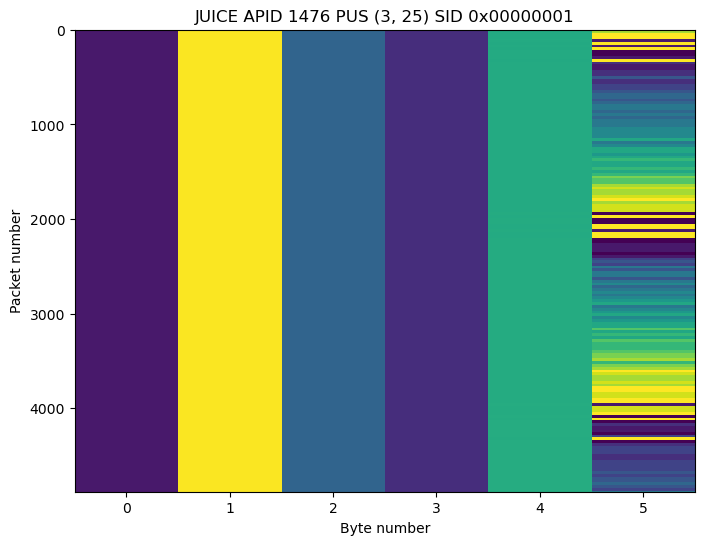

In [85]:
for sid in sorted(apid1476_sids):
    apid1476_sid = np.array([np.frombuffer(a[20:-2], 'uint8') for a in vc0_by_apid[1476]
                            if a[16:20].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid1476_sid, aspect='auto', interpolation='none')
    plt.title(f'JUICE APID 1476 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

## APID 1492

In [86]:
vc0_services_by_apid[1492]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 4879})

In [87]:
apid1492_sids = collections.Counter(a[16:20].hex() for a in vc0_by_apid[1492])
apid1492_sids

Counter({'00000001': 4879})

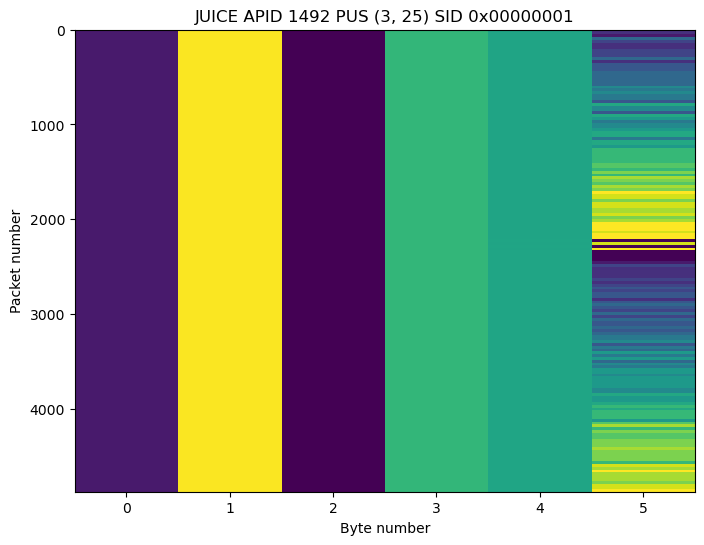

In [88]:
for sid in sorted(apid1492_sids):
    apid1492_sid = np.array([np.frombuffer(a[20:-2], 'uint8') for a in vc0_by_apid[1492]
                            if a[16:20].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid1492_sid, aspect='auto', interpolation='none')
    plt.title(f'JUICE APID 1492 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

## APID 2047

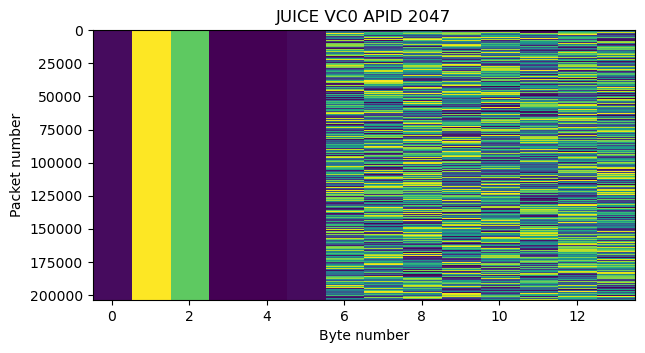

In [89]:
vc0_apid2047 = np.array([np.frombuffer(p, 'uint8') for p in vc0_by_apid[2047]])
plt.imshow(vc0_apid2047, aspect='auto', interpolation='none')
plt.title(f'JUICE VC0 APID 2047')
plt.xlabel('Byte number')
plt.ylabel('Packet number');

In [90]:
collections.Counter([tuple([(k, v) for k, v in h.items() if k != '_io']) for h in vc0_headers if h.APID == 2047])

Counter({(('ccsds_version', 0),
          ('packet_type', 0),
          ('secondary_header_flag', False),
          ('APID', 2047),
          ('sequence_flags', 3),
          ('packet_sequence_count_or_name', 0),
          ('data_length', 7)): 203553})

In [91]:
f_vc0 = [f for f in tm if f.primary_header.virtual_channel_id == 0]
print(f_vc0[1].primary_header)
print()
x = f_vc0[1].m_pdu_packet_zone
a = f_vc0[1].primary_header.first_header_pointer
while a < len(x) - ccsds.SpacePacketPrimaryHeader.sizeof():
    h = ccsds.SpacePacketPrimaryHeader.parse(x[a:])
    print(h)
    a += 7 + h.data_length

Container: 
    transfer_frame_version_number = 0
    spacecraft_id = 844
    virtual_channel_id = 0
    ocf_flag = True
    master_channel_frame_count = 80
    virtual_channel_frame_count = 64
    secondary_header_flag = True
    synch_flag = False
    packet_order_flag = False
    segment_length_id = 3
    first_header_pointer = 217

Container: 
    ccsds_version = 0
    packet_type = 0
    secondary_header_flag = True
    APID = 165
    sequence_flags = 3
    packet_sequence_count_or_name = 2187
    data_length = 166
Container: 
    ccsds_version = 0
    packet_type = 0
    secondary_header_flag = True
    APID = 173
    sequence_flags = 3
    packet_sequence_count_or_name = 16341
    data_length = 366
Container: 
    ccsds_version = 0
    packet_type = 0
    secondary_header_flag = False
    APID = 2047
    sequence_flags = 3
    packet_sequence_count_or_name = 0
    data_length = 7
Container: 
    ccsds_version = 0
    packet_type = 0
    secondary_header_flag = False
    APID = 2

# VC1

VC1 contains CCSDS Space Packets formatted as in VC0. In fact, it seems that VC1 re-sends a selection of some of the APIDs in VC0 (the Space Packets sent in both VCs are the same).

In [92]:
vc1_packets = list(ccsds.extract_space_packets(tm, 0x34c, 1))
vc1_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc1_packets]

In [93]:
vc1_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=173, sequence_flags=3, packet_sequence_count_or_name=16340, data_length=338),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=165, sequence_flags=3, packet_sequence_count_or_name=2187, data_length=166),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=173, sequence_flags=3, packet_sequence_count_or_name=16341, data_length=366),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=7)]

In [94]:
vc1_apids = collections.Counter([p.APID for p in vc1_headers])
vc1_apids

Counter({173: 3411,
         165: 1273,
         2047: 104009,
         164: 1301,
         1476: 897,
         1492: 897,
         172: 30,
         166: 4,
         161: 208})

In [95]:
collections.Counter([(p.APID, p.secondary_header_flag) for p in vc1_headers])

Counter({(173, True): 3411,
         (165, True): 1273,
         (2047, False): 104009,
         (164, True): 1301,
         (1476, True): 897,
         (1492, True): 897,
         (172, True): 30,
         (166, True): 4,
         (161, True): 208})

In [96]:
for apid in sorted(vc1_apids):
    print('APID', apid)
    print('data_lengths', collections.Counter([p.data_length for p in vc1_headers if p.APID == apid]))

APID 161
data_lengths Counter({15: 208})
APID 164
data_lengths Counter({140: 180, 352: 179, 729: 179, 183: 179, 445: 179, 578: 120, 381: 60, 232: 60, 320: 60, 451: 60, 259: 30, 806: 15})
APID 165
data_lengths Counter({1987: 180, 417: 180, 47: 179, 357: 91, 3971: 90, 166: 60, 466: 60, 192: 60, 112: 60, 810: 60, 96: 60, 43: 60, 673: 59, 161: 30, 1673: 29, 3443: 15})
APID 166
data_lengths Counter({2470: 3, 941: 1})
APID 172
data_lengths Counter({1175: 30})
APID 173
data_lengths Counter({338: 1795, 211: 449, 103: 448, 859: 224, 219: 180, 366: 113, 83: 112, 1988: 60, 3611: 30})
APID 1476
data_lengths Counter({21: 897})
APID 1492
data_lengths Counter({21: 897})
APID 2047
data_lengths Counter({7: 104009})


In [97]:
vc1_by_apid = {apid: [p for p, h in zip(vc1_packets, vc1_headers) if h.APID == apid]
               for apid in vc1_apids}
vc1_t_by_apid = {apid: np.array([(to_timestamp_pus if apid != 0 else to_timestamp_not_pus)(p)
                                 for p in vc1_by_apid[apid]])
                 for apid in vc1_apids if apid not in [2047]}
vc1_pus_by_apid = {apid: [PUSHeader.parse(p[ccsds.SpacePacketPrimaryHeader.sizeof():])
                          for p in vc1_by_apid[apid]]
                   for apid in vc1_apids if apid not in [2047]}
vc1_services_by_apid = {
    apid: collections.Counter([pus_service(p) for p in vc1_pus_by_apid[apid]])
    for apid in vc1_apids if apid not in [2047]}

In [98]:
collections.Counter([(p.spare_flag, p.version_number, p.spare, p.destination_id)
                     for pus in vc1_pus_by_apid.values() for p in pus])

Counter({(False, 1, 0, 0): 8021})

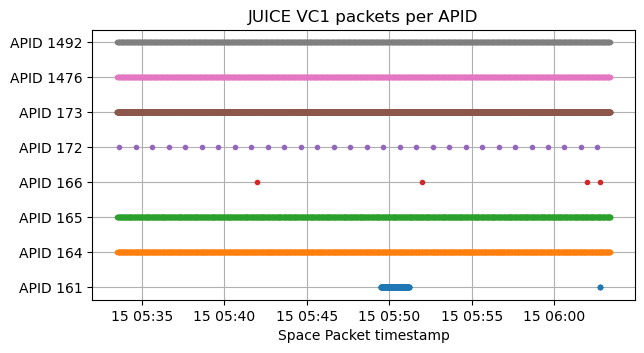

In [99]:
apid_list = sorted([a for a in vc1_apids if a not in [2047]])
for j, apid in enumerate(apid_list):
    plt.plot(vc1_t_by_apid[apid], np.ones(vc1_t_by_apid[apid].size) * j, '.'),
plt.yticks(np.arange(len(apid_list)), [f'APID {a}' for a in apid_list])
plt.grid()
plt.title('JUICE VC1 packets per APID')
plt.xlabel('Space Packet timestamp');

In [100]:
np.max([np.max(a) for a in vc1_t_by_apid.values()])

numpy.datetime64('2023-04-15T06:03:23.877868672')

In [101]:
vc1_tslices = np.datetime64('2023-04-15T05:32') + np.arange(2200 / sec_avg + 1) * np.timedelta64(sec_avg, 's')

In [102]:
vc1_packets_per_second = {
    apid:
    [np.sum((vc1_tslices[j] <= vc1_t_by_apid[apid]) & (vc1_t_by_apid[apid] < vc1_tslices[j+1])) / sec_avg
     for j in range(len(vc1_tslices) - 1)]
    for apid in vc1_apids if apid not in [2047]}

vc1_bytes_per_second = {
    apid:
    [np.sum([len(p) for p, t in zip(vc1_by_apid[apid], vc1_t_by_apid[apid])
             if vc1_tslices[j] <= t < vc1_tslices[j+1]]) / sec_avg
     for j in range(len(vc1_tslices) - 1)]
    for apid in vc1_apids if apid not in [2047]}

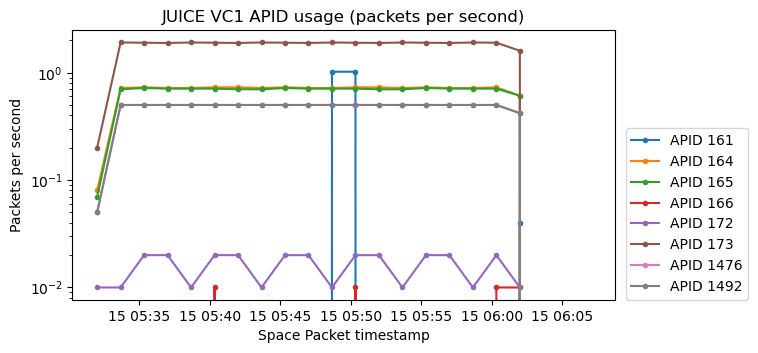

In [103]:
for j, apid in enumerate(sorted(vc1_packets_per_second)):
    plt.semilogy(vc1_tslices[:-1], vc1_packets_per_second[apid], '.-', label=f'APID {apid}')

plt.legend(loc=[1.02,0])
plt.title('JUICE VC1 APID usage (packets per second)')
plt.ylabel('Packets per second')
plt.xlabel('Space Packet timestamp');

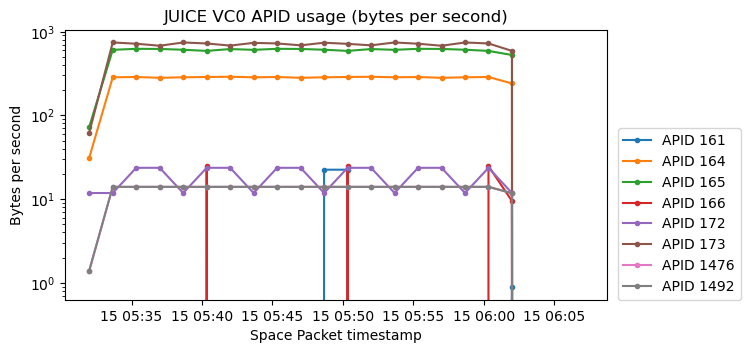

In [104]:
for j, apid in enumerate(sorted(vc1_bytes_per_second)):
    plt.semilogy(vc1_tslices[:-1], vc1_bytes_per_second[apid], '.-', label=f'APID {apid}')

plt.legend(loc=[1.02,0])
plt.ylabel('Bytes per second')
plt.title('JUICE VC0 APID usage (bytes per second)')
plt.xlabel('Space Packet timestamp');

In [105]:
packet_crc_ok_vc1 = [packet_crc.compute(list(p[:-2])) == struct.unpack('>H', p[-2:])[0]
                 for p in vc1_packets if ccsds.SpacePacketPrimaryHeader.parse(p).APID != 2047]
all(packet_crc_ok_vc1)

True

## APID 161

In [106]:
vc1_services_by_apid[161]
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)
# (17, 2) is link connection report (test service)

Counter({(1, 1): 104, (1, 7): 104})

In [107]:
vc1_by_apid[161] == vc0_by_apid[161][:len(vc1_by_apid[161])]

True

## APID 162

In [108]:
vc1_services_by_apid[164]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 1301})

In [109]:
vc1_by_apid[164] == vc0_by_apid[164][1:][:len(vc1_by_apid[164])]

True

## APID 165

In [110]:
vc1_services_by_apid[165]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 1273})

In [111]:
vc1_by_apid[165] == vc0_by_apid[165][:len(vc1_by_apid[165])]

True

## APID 166

In [112]:
vc1_services_by_apid[166]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 4})

In [113]:
vc1_by_apid[166] == vc0_by_apid[166][:len(vc1_by_apid[166])]

True

## APID 172

In [114]:
vc1_services_by_apid[172]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 30})

In [115]:
vc1_by_apid[172] == vc0_by_apid[172][:len(vc1_by_apid[172])]

True

## APID 173

In [116]:
vc1_services_by_apid[173]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 3411})

In [117]:
vc1_by_apid[173] == vc0_by_apid[173][2:][:len(vc1_by_apid[173])]

True

## APID 1476

In [118]:
vc1_services_by_apid[1476]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 897})

In [119]:
vc1_by_apid[1476] == vc0_by_apid[1476][1:][:len(vc1_by_apid[1476])]

True

## APID 1492

In [120]:
vc1_services_by_apid[1492]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 897})

In [121]:
vc1_by_apid[1492] == vc0_by_apid[1492][1:][:len(vc1_by_apid[1492])]

True

# VC4

VC4 contains Space Packets from APID 148 (as well as from the idle APID 2047). APID 148 packets seem to be divided in two similar "halves". At the beginning of each half, there are 32-bit timestamps which count the number of seconds since the J2000 epoch. The timestamps in each half in the same packet have the same value.

In [122]:
vc4_packets = list(ccsds.extract_space_packets(tm, 0x34c, 4))
vc4_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc4_packets]

/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 4] Broken stream. Last frame count 97, current frame count 108
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 4] Broken stream. Last frame count 157, current frame count 169
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 844 VC 4] Broken stream. Last frame count 210, current frame count 212
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/JUICE/ccsds.py:93: UserWa

In [123]:
vc4_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=148, sequence_flags=3, packet_sequence_count_or_name=12590, data_length=247),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=7)]

In [124]:
vc4_apids = collections.Counter([p.APID for p in vc4_headers])
vc4_apids

Counter({148: 279, 2047: 16834})

In [125]:
for apid in sorted(vc4_apids):
    print('APID', apid)
    print('data_lengths', collections.Counter([p.data_length for p in vc4_headers if p.APID == apid]))

APID 148
data_lengths Counter({247: 279})
APID 2047
data_lengths Counter({7: 16834})


In [126]:
vc4_by_apid = {apid: [p for p, h in zip(vc4_packets, vc4_headers) if h.APID == apid]
               for apid in vc4_apids}
apid148 = np.array([np.frombuffer(p, 'uint8') for p in vc4_by_apid[148]])

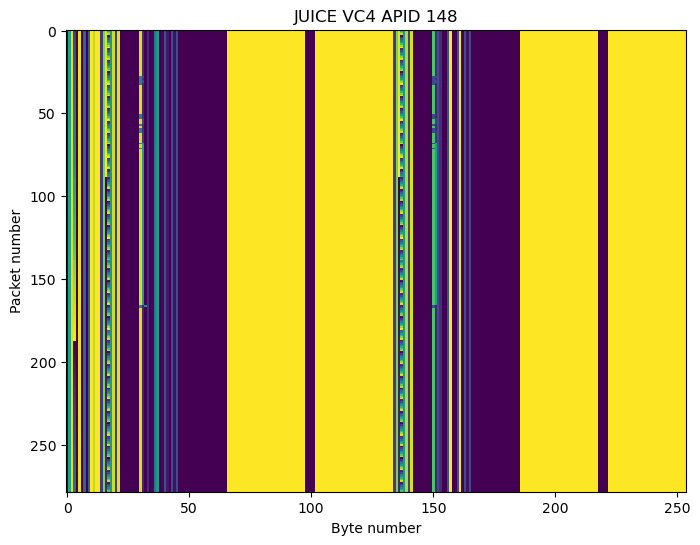

In [127]:
plt.figure(figsize=(8, 6))
plt.imshow(apid148, aspect='auto', interpolation='none')
plt.title('JUICE VC4 APID 148')
plt.xlabel('Byte number')
plt.ylabel('Packet number');

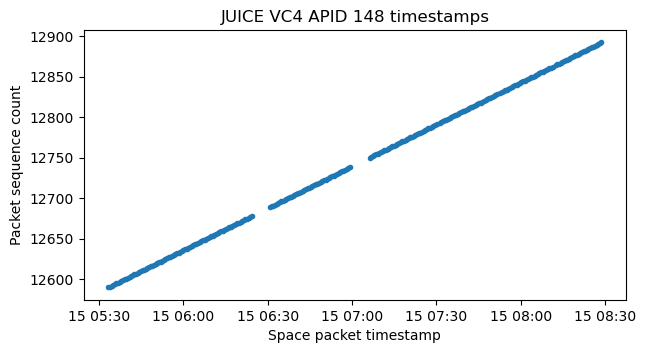

In [128]:
apid148_timestamps = to_timestamp(apid148[:, 14:18])
apid148_timestamps2 = to_timestamp(apid148[:, 134:138])
plt.plot(apid148_timestamps, [h.packet_sequence_count_or_name for h in vc4_headers if h.APID == 148], '.')
plt.title('JUICE VC4 APID 148 timestamps')
plt.ylabel('Packet sequence count')
plt.xlabel('Space packet timestamp');

In [129]:
np.all(apid148_timestamps2 == apid148_timestamps)

True

In [130]:
np.diff(apid148_timestamps)

array([ 34,  35,  35,  35,  35,  35,  34,  35,  35,  35,  35,  35,  35,
        34,  35,  35,  35,  35,  35,  35,  34,  35,  35,  35,  35,  35,
        34,  35,  35,  35,  35,  35,  35,  34,  35,  35,  35,  35,  35,
        35,  34,  35,  35,  35,  35,  35,  34,  35,  35,  35,  35,  35,
        35,  34,  35,  35,  35,  35,  35,  35,  34,  35,  35,  35,  35,
        35,  34,  35,  35,  35,  35,  35,  35,  34,  35,  35,  35,  35,
        35,  35,  34,  35,  35,  35,  35,  35,  34,  35, 384,  35,  34,
        35,  35,  35,  35,  35,  34,  35,  35,  35,  35,  35,  35,  34,
        35,  35,  35,  35,  35,  35,  34,  35,  35,  35,  35,  35,  34,
        35,  35,  35,  35,  35,  35,  34,  35,  35,  35,  35,  35,  34,
        35,  35,  35,  35,  35,  35,  34,  35, 418,  35,  35,  35,  35,
        35,  35,  34,  35,  35,  35,  35,  35,  35,  34,  35,  35,  35,
        35,  35,  34,  35,  35,  35,  35,  35,  35,  34,  35,  35,  35,
        35,  35,  35,  34,  35,  35,  35,  35,  35,  34,  35,  7

# VC7

VC7 is the idle APID. The payload of the frames is filled by a PN9 sequence in the same [way as for BepiColombo](https://destevez.net/2020/04/idle-data-in-bepicolombo-x-band-signal/).

In [131]:
vc7_frames = frames[vcid == 7]

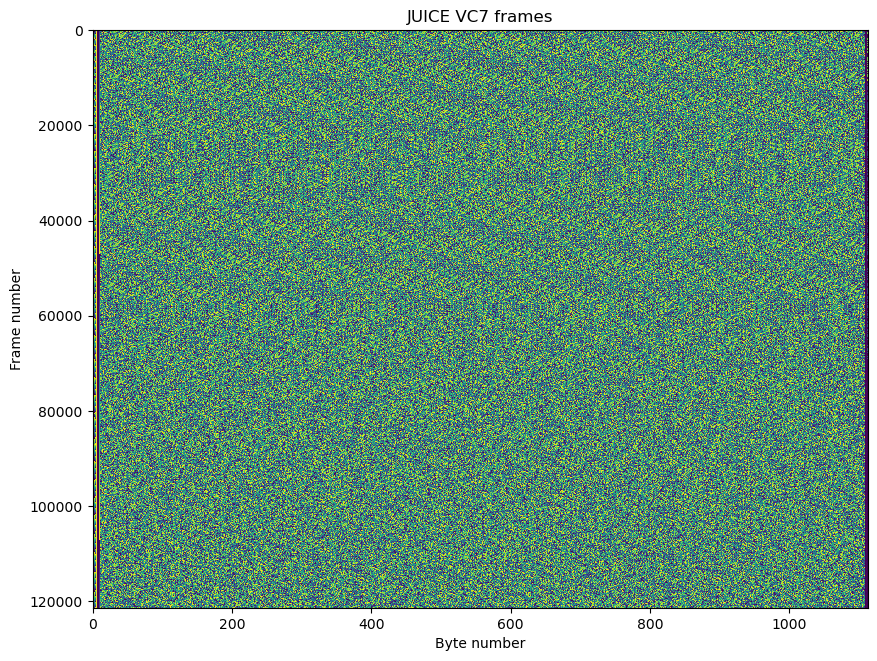

In [132]:
plt.figure(figsize=(10, 7.5))
plt.imshow(vc7_frames, aspect='auto', interpolation='none')
plt.title('JUICE VC7 frames')
plt.xlabel('Byte number')
plt.ylabel('Frame number');

In [133]:
lfsr = np.ones(9, dtype = 'uint8')
lfsr_out = np.empty(511, dtype = 'uint8')
for j in range(lfsr_out.size):
    out = lfsr[8] ^ lfsr[4]
    lfsr_out[j] = lfsr[8]
    lfsr = np.roll(lfsr, 1)
    lfsr[0] = out
    
def gen_idle_payload(vcfc):
    start = (8792 * vcfc) % 511
    lfsr_out_repeat = np.tile(lfsr_out, int(np.ceil(8792 / 511)) + 2)
    return bytes(np.packbits(lfsr_out_repeat[start:start+8792]))

for frame in tm:
    if frame.primary_header.virtual_channel_id == 7:
        assert frame.m_pdu_packet_zone == gen_idle_payload(frame.primary_header.virtual_channel_frame_count)

# CLCW

The CLCWs contained in the OCF (operation control field) alternate between VC1 and VC2 (frames with even master channel frame count report for VC1, and frames with odd master channel frame count report for VC2).

There is the following relation between the no RF available and no bit lock fields: no RF available implies no bit lock (this is to be expected).

In [134]:
clcw = [a.clcw for a in tm]

In [135]:
clcw[:4]

[Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=1, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=1, rsvd_spare2=0, report_value=204),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=2, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=2, rsvd_spare2=0, report_value=0),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=1, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=1, rsvd_spare2=0, report_value=204),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=2, rsvd_spare=0, no_rf_avail=False, no_bit_lock=Fal

In [136]:
collections.Counter([(c.control_word_type, c.clcw_version_number, c.status_field, c.cop_in_effect,
                      c.rsvd_spare, c.rsvd_spare2, c.retransmit, c.lock_out, c.wait)
                     for c in clcw])

Counter({(False, 0, 0, 1, 0, 0, False, False, False): 143182})

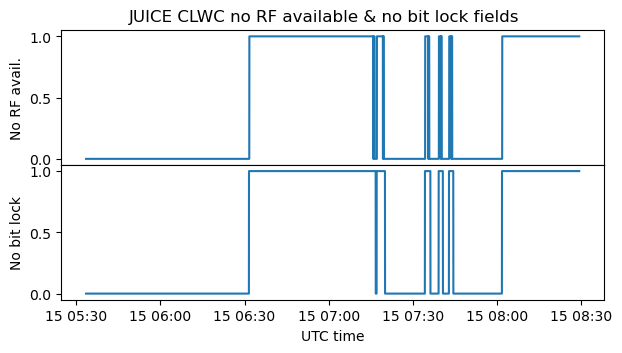

In [137]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
axs[0].plot(t_frame, [c.no_rf_avail for c in clcw])
axs[0].set_ylabel('No RF avail.')
axs[1].plot(t_frame, [c.no_bit_lock for c in clcw])
axs[1].set_ylabel('No bit lock')
plt.subplots_adjust(hspace=0)
plt.xlabel('UTC time')
plt.suptitle('JUICE CLWC no RF available & no bit lock fields', y=0.94);

In [138]:
all([not c.no_rf_avail or c.no_bit_lock for c in clcw])

True

In [139]:
collections.Counter([c.virtual_channel_identification for c in clcw])

Counter({1: 71609, 2: 71573})

In [140]:
collections.Counter((m % 2, c.virtual_channel_identification) for m, c in zip(mcfc, clcw))

Counter({(0, 1): 71609, (1, 2): 71573})

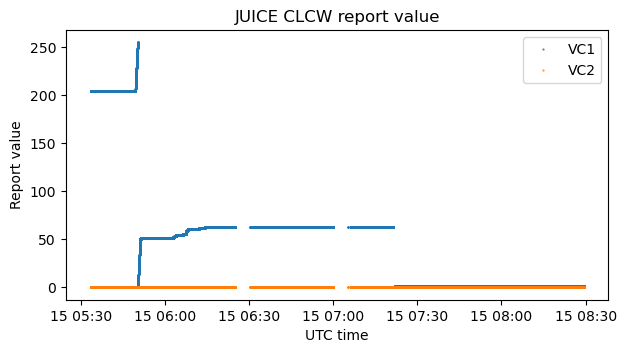

In [141]:
cvc = np.array([c.virtual_channel_identification for c in clcw])
report_vc1 = np.array([c.report_value for c in clcw if c.virtual_channel_identification == 1])
report_vc2 = np.array([c.report_value for c in clcw if c.virtual_channel_identification == 2])
plt.plot(t_frame[cvc == 1], report_vc1, '.', label='VC1', markersize=1)
plt.plot(t_frame[cvc == 2], report_vc2, '.', label='VC2', markersize=1)
plt.legend()
plt.title('JUICE CLCW report value')
plt.ylabel('Report value')
plt.xlabel('UTC time');

In [142]:
np.unique(report_vc2)

array([0])

In [143]:
d = np.diff(report_vc1)
d[d != 0]

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1, -255,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,  -62,    1])

In [144]:
t_frame[cvc == 1][41500:43000][np.where(report_vc1[41500:43000] == 1)[0][0]]

numpy.datetime64('2023-04-15T07:21:28.458626142')

In [145]:
t_frame[cvc == 1][41500:43000][np.where(report_vc1[41500:43000] == 2)[0][0]]

numpy.datetime64('2023-04-15T07:22:10.115184075')

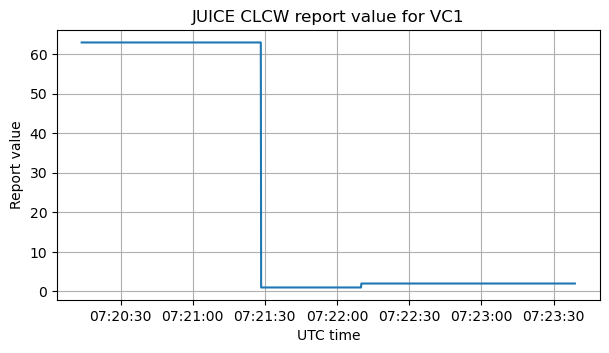

In [146]:
plt.plot(t_frame[cvc == 1][41500:43000], report_vc1[41500:43000])
plt.title('JUICE CLCW report value for VC1')
plt.ylabel('Report value')
plt.xlabel('UTC time')
plt.grid();

In [147]:
report_vc1[-1]

2

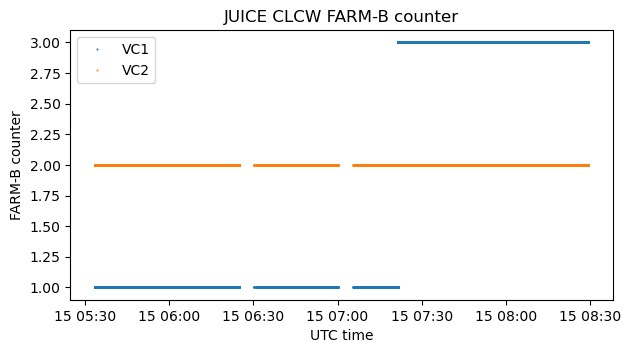

In [148]:
farm_b_counter_vc1 = np.array([c.farm_b_counter for c in clcw if c.virtual_channel_identification == 1])
farm_b_counter_vc2 = np.array([c.farm_b_counter for c in clcw if c.virtual_channel_identification == 2])
plt.plot(t_frame[cvc == 1], farm_b_counter_vc1, '.', label='VC1', markersize=1)
plt.plot(t_frame[cvc == 2], farm_b_counter_vc2, '.', label='VC2', markersize=1)
plt.legend()
plt.title('JUICE CLCW FARM-B counter')
plt.ylabel('FARM-B counter')
plt.xlabel('UTC time');

In [149]:
d = np.diff(farm_b_counter_vc1)
d[d != 0]

array([1, 1])

In [150]:
t_frame[cvc == 1][np.where(d != 0)[0]]

array(['2023-04-15T07:21:28.322493599', '2023-04-15T07:21:39.757627150'],
      dtype='datetime64[ns]')

In [151]:
np.unique(farm_b_counter_vc2)

array([2])